# MIS
In a graph, the maximal independent set, also known as maximal stable set is an independent set that is not a subset of any other independent set. In other words, it is a set of vertices such that no two vertices in the set are adjacent. In this notebook, we will build a learning-based model to find the maximal independent set in a graph.

<img src="img/Independent_set_graph.png" alt="Solved MIS" style="width:400px; height:400px;">

SeaPearl currently supports learning-based value selection models trained with Reinforcement Learning. To train Reinforcement Learning agents, we start by generating training instances and we let the agent learn a value selection heuristic. Like all other Reinforcement Learning tasks, we need to define a reward function, a state representation and an action space. Finally, we also need to build a neural network that will learn the value selection heuristic. All of these components will be defined in the following sections.

## Setup
We will begin by activating the environment and importing the necessary packages.

In [1]:
using Revise
using Pkg
Pkg.activate("../../../")
Pkg.instantiate()
using SeaPearl
using Flux
using LightGraphs
using Random
using BSON: @save, @load
using ReinforcementLearning
using CSV
const RL = ReinforcementLearning

  Activating project at `c:\Users\leobo\Desktop\École\Poly\SeaPearl\SeaPearlZoo.jl`


ReinforcementLearning

## Generating instances

SeaPearl provides a number of instance generators, including one for the MIS problem. Under the hood, this generator creates Barabasi-Albert graphs with `n` vertices. The graphs are grown by adding new vertices to an initial that has `k` vertices. New vertices are connected by `k` edges to `k` different vertices already present in the system by preferential attachment. The resulting graphs are undirected.

<img src="img/450px-Barabasi_albert_graph.png" alt="Barabasi-Albert Graph" style="width:600px; height:200px;">

In [89]:
numInitialVertices = 4
numNewVertices = 6
instance_generator = SeaPearl.MaximumIndependentSetGenerator(numNewVertices, numInitialVertices)

SeaPearl.MaximumIndependentSetGenerator(6, 4)

## The Reinforcement Learning setup

### The state representation
In SeaPearl, the state $s_t$ is defined as a pair $s_t = (P_t, x_t)$, with $P_t$ a partially solved combinatorial optimization problem and $x_t$ a variable selected at time $t$ of an episode. A terminal episode is reached if all variables are fixed or if a failure is detected.

### The action space
Given a state $s_t = (P_t, x_t)$, an action $a_t$ represents the selection of a value $v$ for the variable $x_t$. The action space is defined as the set of all possible values for the variable $x_t$ at time $t$.

### The transition function
Given a state $s_t = (P_t, x_t)$ and an action $a_t = v$, the transition function is comprised of three steps;
1. The value of variable $x_{267}$ is assigned as $v$ (i.e., $D(x_{t+1}) = v$).
2. The fix-point operation is applied on $P_t$ to prune the domains (i.e., $P_{t+1} = \text{{fixPoint}}(P_t)$).
3. The next variable to branch on is selected (i.e., $x_{t+1} = \text{{nextVariable}}(P_{t+1})$).
This results in a new state $s_{t+1} = (P_{t+1}, x_{t+1})$.


### The reward function
SeaPearl uses a "propagation-based reward". As the goal of the agent is to quickly find a good solution, it needs to learn to effectively prune the search space and move toward promising regions. An intuitive way to configure the reward is to give the agent the objective value, but this information is only available at the end of episodes. In other words, it makes the reward signal extremely sparse. To address this problem, SeaPearl uses both an intermediate reward and a final reward. The intuition behind the intermediate reward is this: it is computed by rewarding the pruning of high values from the variable's domain and penalizing the pruning of low values from the variable's domain. Mathematcially, the intermediate reward is defined as follows:

$$

r_t^{ub} = \{ v \in D_t(x_{\text{{obj}}}) \mid v \notin D_{t+1}(x_{\text{{obj}}}) \land v > \max(D_t(x_{\text{{obj}}})) \} \\
r_t^{lb} = \{ v \in D_t(x_{\text{{obj}}}) \mid v \notin D_{t+1}(x_{\text{{obj}}}) \land v < \min(D_t(x_{\text{{obj}}})) \} \\
r^{mid}_t = \frac{{r_t^{ub} - r_t^{lb}}}{{\lvert D_1(x_{\text{{obj}}}) \rvert}} \\
r^{end}_t = \begin{cases} -1 & \text{{if unfeasible solution found}} \\ 0 & \text{{otherwise}} \end{cases} \\
r_{acc} = \frac{{\sum_{t=1}^{T} (r^{mid}_t + r^{end}_t)}}{{T-1}}
$$

## Implementation

We will now begin to implement the MIS problem in SeaPearl. To start, we will define the reward, which comes directly from the mathematical definition above. It is implemented in the `GeneralReward` of SeaPearl.


In [3]:
reward = SeaPearl.GeneralReward

SeaPearl.GeneralReward

# The Neural Network

Next up, we need to define the neural network that will learn the value selection function. As the problems can differ in size, the use of graph neural networks (GNNs) is particularly appropriate. GNNs are a class of neural networks that operate on graphs, which means we need to convert the problem instances to graphs. In SeaPearl, we use tripartite graphs, which are graphs with three types of nodes: variables, values and constraints. There is one node for every variable, for every value and for every constraint. The edges are defined as follows:
 - There is an edge between a variable and a value if the value is in the domain of the variable.
 - There is an edge between a variable and a constraint if the variable appears in the constraint.

Nodes have the following features:
 - Values have a one-hot encoding of their value. For example, if the domain of a variable is $\{1, 2, 3\}$, then the values will have a one-hot encoding of $[1, 2, 3]$.
 - Constraints have a one-hot encoding of their type (i.e., constraint).

Other features can be used in the graph and we will define a featurization for it later on.

## Setting up the experiment

In the next cell, we will set up the experiment. We will create structs for the agent and the experiment. We will also define the hyperparameters of the experiment.

In [90]:
"""MisAgentConfig holds parameters for the configuration of the RL agent that will be used"""

#++ add comments for each field
struct MisAgentConfig
    gamma::Float32
    batch_size::Int
    output_size::Int
    update_horizon::Int
    min_replay_history::Int
    update_freq::Int
    target_update_freq::Int
    trajectory_capacity::Int
end

"""MisExperimentSettings holds parameters for the configuration of the experiment"""
struct MisExperimentSettings
    nbEpisodes::Int
    restartPerInstances::Int
    evalFreq::Int
    nbInstances::Int
    nbRandomHeuristics::Int
    nbNewVertices::Int
    nbInitialVertices::Int
    seedEval::Int
end

agent_config = MisAgentConfig(0.99f0, 64, instance_generator.n, 4, 400, 1, 20, 2000)
mis_settings = MisExperimentSettings(1000, 1, 10, 10, 1, numNewVertices, numInitialVertices, 123)

MisExperimentSettings(1000, 1, 10, 10, 1, 6, 4, 123)

## Further configuration

Next up, we will define additional configurations for the experiment:
- The random seed
- Number of steps per episode
- The update horizon
- The device to use (CPU or GPU)
- The evaluation frequency
- The steps for the explorer
- The parameter initialization function

In [91]:
n_step_per_episode = Int(round(mis_settings.nbNewVertices // 2)) + mis_settings.nbInitialVertices
update_horizon = Int(round(n_step_per_episode // 2))
device = cpu # change if you have a GPU

if device == gpu
    CUDA.device!(numDevice)
end

evalFreq = mis_settings.evalFreq
step_explorer = Int(floor(mis_settings.nbEpisodes * n_step_per_episode / 2))
generator = instance_generator
eval_generator = generator

rngExp = MersenneTwister(mis_settings.seedEval)
init = Flux.glorot_uniform(MersenneTwister(mis_settings.seedEval))

#1 (generic function with 1 method)

## The State Representation

The state representation is defined in the `HeterogeneousStateRepresentation` class. It is a heterogeneous state representation, which means that it is comprised of multiple state representations. In this example, we will use the `DefaultFeaturization` and the `HeterogeneousTrajectoryState` state representations. The `DefaultFeaturization` state representation is a featurization that is used by default in SeaPearl and allows the user to select the graph features they want. The available features are the following.
### Variable Features:
- node_number_of_neighbors
- variable_initial_domain_size
- variable_domain_size
- variable_is_bound
- variable_is_branchable
- variable_is_objective
- variable_assigned_value
### Constraint Features
- node_number_of_neighbors
- constraint_activity
- nb_involved_constraint_propagation
- nb_not_bounded_variable
- constraint_type
### Value Features
- node_number_of_neighbors
- values_raw
- values_onehot

The featurization is used to convert the problem instance to a graph. The `HeterogeneousTrajectoryState` state representation is a state representation that is used to represent the state at a given point in the resolution of the problem. It contains the variable that is branched on, the feature graph at that point and the available values.

In [92]:
# Defines the features that will be used
chosen_features = Dict(
    "node_number_of_neighbors" => true,
    "constraint_type" => true,
    "constraint_activity" => true,
    "nb_not_bounded_variable" => true,
    "variable_initial_domain_size" => true,
    "variable_domain_size" => true,
    "variable_is_objective" => true,
    "variable_assigned_value" => true,
    "variable_is_bound" => true,
    "values_raw" => true
)
SR_heterogeneous = SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization,SeaPearl.HeterogeneousTrajectoryState}

SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}

## Defining the Neural Network
Link to SeaPearl - tom - paper.

In the next cell, we will define the neural network used by the RL agent. We will be using Graph Neural Networks (GNNs) as the learnable architecture. The inputs will be graphs as defined earlier. The features are defined in a Dict and contain elements coming from the problem instance.

## The GNN model

The model used in this example is the Heterogeneous Graph Convolutional Network (HetGCN) proposed by Zhang et al. in [Heterogeneous Graph Neural Network](https://arxiv.org/abs/2003.01332). The model is defined as follows:
For each relation type $r \in R $:
- $H^{(l)}_{r} = \sigma(D_{r}^{-\frac{1}{2}}A_{r}D_{r}^{-\frac{1}{2}}H^{(l-1)}_{r}W^{(l)}_{r})$ 
- Where:
- $H^{(l)}_{r}$ denotes the feature matrix of nodes of type $r$ in layer $l$.
- $A_{r}$ is the adjacency matrix for the relation $r$.
- $D_{r}$ is the degree matrix for the adjacency matrix $A_{r}$.
- $W^{(l)}_{r}$ is a layer-specific learnable weight matrix for nodes of type $r$.
- $\sigma$ is the activation function such as ReLU.
- Finally, to obtain a comprehensive feature representation of nodes, the feature representations obtained from different relations are concatenated:
- $H^{(l)}$ = CONCAT $(H^{(l)}_{r_1}, H^{(l)}_{r_2}, ..., H^{(l)}_{r_n})$
- Where  $r_1$, $r_2$, ..., $r_n$ are different types of relations.

In SeaPearl, the heterogeneous GCN is implemented in the HeterogeneousCPNN class.

In [93]:
struct HeterogeneousModel{A,B}
    Inputlayer::A
    Middlelayers::Vector{B}
end

# The size of the input features for each type of node (variable, constraint, value), respectively
feature_size = [6, 5, 2]

"""
    get_dense_chain(in, mid, out, n_layers, σ=Flux.identity; init=Flux.glorot_uniform)

Create a chain of dense layers for a neural network.

# Arguments
- `in::Int`: The size of the input layer.
- `mid::Int`: The size of the intermediate layers.
- `out::Int`: The size of the output layer.
- `n_layers::Int`: The number of layers in the chain.
- `σ::Function=Flux.identity`: The activation function to use.
- `init::Function=Flux.glorot_uniform`: The initialization method to use.

# Returns
A `Flux.Chain` object representing the chain of dense layers.

# Examples
```julia
julia> get_dense_chain(10, 20, 5, 3)
Chain(Dense(10, 20, σ), Dense(20, 20, σ), Dense(20, 5))
```
"""
function get_dense_chain(in, mid, out, n_layers, σ=Flux.identity; init=Flux.glorot_uniform)
    @assert n_layers >= 1
    layers = []
    if n_layers == 1
        push!(layers, Flux.Dense(in, out, init=init))
    elseif n_layers == 2
        push!(layers, Flux.Dense(in, mid, σ, init=init))
        push!(layers, Flux.Dense(mid, out, init=init))
    else
        push!(layers, Flux.Dense(in, mid, σ, init=init))
        for i in 2:(n_layers-1)
            push!(layers, Flux.Dense(mid, mid, σ, init=init))
        end
        push!(layers, Flux.Dense(mid, out, init=init))
    end
    return Flux.Chain(layers...)
end

# Builds the SeaPearl HeterogeneousFullFeaturedCPNN model
function build_model(; 
        feature_size,
        conv_size=8,
        dense_size=16,
        output_size=1,
        n_layers_graph=3,
        n_layers_node=2,
        n_layers_output=2,
        pool=SeaPearl.meanPooling(),
        σ=Flux.leakyrelu,
        init=Flux.glorot_uniform,
        device=cpu
    )
    input_layer = SeaPearl.HeterogeneousGraphConvInit(feature_size, conv_size, σ, init=init) # input layer
    middle_layers = SeaPearl.HeterogeneousGraphConv[] # middle layers
    for i in 1:n_layers_graph-1
        push!(middle_layers, SeaPearl.HeterogeneousGraphConv(conv_size => conv_size, feature_size, σ, pool=pool, init=init))
    end
    output_layer = SeaPearl.HeterogeneousGraphConv(conv_size => output_size, feature_size, σ, pool=pool, init=init) # output layer
    dense_layers = get_dense_chain(conv_size, dense_size, dense_size, n_layers_node, σ, init=init) # dense layers
    # Define the final output layer
    final_output_layer = get_dense_chain(2 * dense_size, dense_size, output_size, n_layers_output, σ, init=init)

    # Build the model
    model = SeaPearl.HeterogeneousFullFeaturedCPNN(
        HeterogeneousModel(input_layer, middle_layers),
        dense_layers,
        Flux.Chain(),
        final_output_layer
    ) |> device

    return model
end

build_model (generic function with 1 method)

## The Agent, Replay Buffer and Exploration Policy

We now have:
- The reward function
- An instance generator
- A GNN
- And all the settings we need!

We now need to define:
- The way we will store trajectories will be stored (in a circular buffer)
- The exploration policy (eps-greedy)
- The agent (DQN)

In [94]:
"""
    get_heterogeneous_slart_trajectory(; capacity, n_actions)

Create a circular buffer for storing trajectories in the context of reinforcement learning where not all actions are legal. 
SLART stands for State, Legal Actions, Reward, Terminal.

# Arguments
- `capacity::Int`: The maximum number of trajectories that can be stored in the buffer.
- `n_actions::Int`: The number of possible actions that can be taken at each time step.

# Returns
A `CircularArraySLARTTrajectory` object with the specified capacity and legal actions mask, and an empty state buffer.
"""
function get_heterogeneous_slart_trajectory(; capacity, n_actions)
    return RL.CircularArraySLARTTrajectory(
        capacity=capacity,
        state=SeaPearl.HeterogeneousTrajectoryState[] => (),
        legal_actions_mask=Vector{Bool} => (n_actions,),
    )
end

function get_heterogeneous_agent(; get_explorer, batch_size=16, update_horizon, min_replay_history, update_freq=1, target_update_freq=200, γ=0.999f0, get_heterogeneous_trajectory, get_heterogeneous_nn)
    return RL.Agent(
        policy=RL.QBasedPolicy(
            learner=get_heterogeneous_learner(batch_size, update_horizon, min_replay_history, update_freq, target_update_freq, get_heterogeneous_nn, γ),
            explorer=get_explorer(),
        ),
        trajectory=get_heterogeneous_trajectory()
    )
end

function get_heterogeneous_learner(batch_size, update_horizon, min_replay_history, update_freq, target_update_freq, get_heterogeneous_nn, γ)
    return RL.DQNLearner(
        approximator=RL.NeuralNetworkApproximator(
            model=get_heterogeneous_nn(),
            optimizer=ADAM()
        ),
        target_approximator=RL.NeuralNetworkApproximator(
            model=get_heterogeneous_nn(),
            optimizer=ADAM()
        ),
        loss_func=Flux.Losses.huber_loss,
        batch_size=batch_size,
        update_horizon=update_horizon,
        min_replay_history=min_replay_history,
        update_freq=update_freq,
        target_update_freq=target_update_freq,
        γ=γ
    )
end

Flux.@functor HeterogeneousModel # To allow automatic differentiation
"""
function Flux.functor(::Type{<:HeterogeneousModel}, m)
    return (m.Inputlayer, m.Middlelayers), ls -> HeterogeneousModel(ls[1], ls[2])
end
"""
function (m::HeterogeneousModel)(fg)
    original_fg = deepcopy(fg)
    out = m.Inputlayer(fg)
    for layer in m.Middlelayers
        out = layer(out, original_fg)
    end
    return out
end

"""
    get_epsilon_greedy_explorer(decay_steps, ϵ_stable; rng=nothing)

Create an epsilon-greedy explorer for use in reinforcement learning.

# Arguments
- `decay_steps::Int`: The number of steps over which to decay the exploration rate.
- `ϵ_stable::Real`: The minimum exploration rate to use after decay.
- `rng::AbstractRNG`: (optional) A random number generator to use for sampling actions.

# Returns
An `EpsilonGreedyExplorer` object with the specified exploration rate decay and random number generator.
"""
function get_epsilon_greedy_explorer(decay_steps, ϵ_stable; rng=nothing)
    if isnothing(rng)
        return RL.EpsilonGreedyExplorer(
            ϵ_stable=ϵ_stable,
            kind=:exp,
            decay_steps=decay_steps,
            step=1
        )
    else
        return RL.EpsilonGreedyExplorer(
            ϵ_stable=ϵ_stable,
            kind=:exp,
            decay_steps=decay_steps,
            step=1,
            rng=rng
        )
    end
end


get_epsilon_greedy_explorer

## The agent definition

## Agent definition

The agent and the related learned heuristic are defined here.

In [95]:
pool = SeaPearl.meanPooling()

agent = get_heterogeneous_agent(;
    get_heterogeneous_trajectory=() -> get_heterogeneous_slart_trajectory(capacity=agent_config.trajectory_capacity, n_actions=2),
    get_explorer=() -> get_epsilon_greedy_explorer(step_explorer, 0.01; rng=rngExp),
    batch_size=agent_config.batch_size,
    update_horizon=update_horizon,
    min_replay_history=Int(round(16 * n_step_per_episode // 2)),
    update_freq=agent_config.update_freq,
    target_update_freq=agent_config.target_update_freq,
    get_heterogeneous_nn=() -> build_model(
        feature_size=feature_size,
        conv_size=8,
        dense_size=16,
        output_size=1,
        n_layers_graph=3,
        n_layers_node=3,
        n_layers_output=2,
        pool=pool,
        σ=NNlib.leakyrelu,
        init=init,
        device=device
    ),
    γ=0.99f0
)

learned_heuristic = SeaPearl.SimpleLearnedHeuristic{SR_heterogeneous,reward,SeaPearl.FixedOutput}(agent; chosen_features=chosen_features)

SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}(typename(Agent)
├─ policy => typename(QBasedPolicy)
│  ├─ learner => typename(DQNLearner)
│  │  ├─ approximator => typename(NeuralNetworkApproximator)
│  │  │  ├─ model => typename(SeaPearl.HeterogeneousFullFeaturedCPNN)
│  │  │  │  ├─ graphChain => typename(HeterogeneousModel)
│  │  │  │  │  ├─ Inputlayer => typename(SeaPearl.HeterogeneousGraphConvInit)
│  │  │  │  │  │  ├─ weightsvar => 8×6 Matrix{Float32}
│  │  │  │  │  │  ├─ weightscon => 8×5 Matrix{Float32}
│  │  │  │  │  │  ├─ weightsval => 8×2 Matrix{Float32}
│  │  │  │  │  │  ├─ biasvar => 8-element Vector{Float32}
│  │  │  │  │  │  ├─ biascon => 8-element Vector{Float32}
│  │  │  │  │  │  ├─ biasval => 8-element Vector{Float32}
│  │  │  │  │  │  └─ σ => typename(typeof(leakyrelu))
│  │  │  │  │  └─ Middlelayers => 2-element Vector{SeaPearl

## Setting up comparisons and running the experiment

We now have everything we need to run the experiment. We will run the experiment for 1000 episodes and compare the performance of the agent with the performance of a random agent and another policy that always selects the max value available.


In [96]:
selectMax(x::SeaPearl.IntVar; cpmodel=nothing) = SeaPearl.maximum(x.domain)
heuristic_max = SeaPearl.BasicHeuristic(selectMax)

function select_random_value(x::SeaPearl.IntVar; cpmodel=nothing)
    selected_number = rand(1:length(x.domain))
    i = 1
    for value in x.domain
        if i == selected_number
            return value
        end
        i += 1
    end
    @assert false "This should not happen"
end

randomHeuristics = []
for i in 1:mis_settings.nbRandomHeuristics
    push!(randomHeuristics, SeaPearl.BasicHeuristic(select_random_value))
end

valueSelectionArray = [learned_heuristic, heuristic_max]
append!(valueSelectionArray, randomHeuristics)
variableSelection = SeaPearl.MinDomainVariableSelection{false}()

SeaPearl.MinDomainVariableSelection{false}()

## Solving the problem

Let's finally build a function that will help solve the problem.

In [97]:
function learning_mis(
    agent::RL.Agent,
    agent_config::MisAgentConfig,
    mis_settings::MisExperimentSettings,
    instance_generator::SeaPearl.AbstractModelGenerator,
    save_experiment_parameters::Bool=false,
    save_model::Bool=false
)
    # To save the learned model
    if save_experiment_parameters
        experiment_time = now()
        dir = mkdir(string("exp_", Base.replace("$(round(experiment_time, Dates.Second(3)))", ":" => "-")))
        experiment_parameters = get_experiment_parameters(agent, agent_config, mis_settings)
        open(dir * "/params.json", "w") do file
            JSON.print(file, experiment_parameters)
        end
    end

    metricsArray, eval_metricsArray = SeaPearl.train!(
        valueSelectionArray=valueSelectionArray,
        generator=instance_generator,
        nbEpisodes=mis_settings.nbEpisodes,
        strategy=SeaPearl.DFSearch(),
        variableHeuristic=variableSelection,
        out_solver=true,
        verbose=false,
        evaluator=SeaPearl.SameInstancesEvaluator(valueSelectionArray, instance_generator; evalFreq=mis_settings.evalFreq, nbInstances=mis_settings.nbInstances),
        restartPerInstances=mis_settings.restartPerInstances
    )
    if save_model
        model = agent.policy.learner.approximator
        @save dir * "/model_gc" * string(instance_generator.n) * ".bson" model
    end

    return metricsArray, eval_metricsArray
end

learning_mis (generic function with 3 methods)

In [98]:
metricsArray, eval_metricsArray = learning_mis(agent, agent_config, mis_settings, instance_generator)

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristic

0.0%┣                                             ┫ 0/1.0k [00:00<00:00, -0s/it]


Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

0.1%┣                                         ┫ 1/1.0k [00:01<Inf:Inf, InfGs/it]
1.1%┣▌                                            ┫ 11/1.0k [00:01<02:13, 7it/s]
1.8%┣▉                                           ┫ 18/1.0k [00:02<01:33, 11it/s]
1.9%┣▉                                           ┫ 19/1.0k [00:02<01:31, 11it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

2.0%┣▉                                           ┫ 20/1.0k [00:02<01:35, 10it/s]
2.1%┣█                                            ┫ 21/1.0k [00:03<02:09, 8it/s]
2.2%┣█                                            ┫ 22/1.0k [00:03<02:10, 8it/s]
2.3%┣█                                            ┫ 23/1.0k [00:03<02:11, 7it/s]
2.4%┣█                                            ┫ 24/1.0k [00:03<02:16, 7it/s]
2.5%┣█▏                                           ┫ 25/1.0k [00:03<02:12, 7it/s]
2.6%┣█▏                                           ┫ 26/1.0k [00:03<02:13, 7it/s]
2.7%┣█▏                                           ┫ 27/1.0k [00:04<02:13, 7it/s]
2.8%┣█▎                                           ┫ 28/1.0k [00:04<02:13, 7it/s]
2.9%┣█▎                                           ┫ 29/1.0k [00:04<02:14, 7it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

3.0%┣█▍                                           ┫ 30/1.0k [00:04<02:14, 7it/s]


BasicHeuristic

3.1%┣█▍                                           ┫ 31/1.0k [00:05<02:32, 6it/s]
3.2%┣█▍                                           ┫ 32/1.0k [00:05<02:30, 6it/s]
3.3%┣█▌                                           ┫ 33/1.0k [00:05<02:31, 6it/s]
3.4%┣█▌                                           ┫ 34/1.0k [00:05<02:30, 6it/s]
3.5%┣█▋                                           ┫ 35/1.0k [00:05<02:30, 6it/s]
3.7%┣█▋                                           ┫ 37/1.0k [00:06<02:28, 7it/s]
3.8%┣█▊                                           ┫ 38/1.0k [00:06<02:28, 6it/s]
3.9%┣█▊                                           ┫ 39/1.0k [00:06<02:27, 7it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

4.0%┣█▉                                           ┫ 40/1.0k [00:06<02:27, 7it/s]


BasicHeuristic

4.1%┣█▉                                           ┫ 41/1.0k [00:07<02:43, 6it/s]
4.2%┣██                                           ┫ 42/1.0k [00:07<02:42, 6it/s]
4.3%┣██                                           ┫ 43/1.0k [00:07<02:42, 6it/s]
4.5%┣██                                           ┫ 45/1.0k [00:07<02:37, 6it/s]
4.6%┣██                                           ┫ 46/1.0k [00:07<02:37, 6it/s]
4.7%┣██▏                                          ┫ 47/1.0k [00:08<02:36, 6it/s]
4.8%┣██▏                                          ┫ 48/1.0k [00:08<02:36, 6it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


4.9%┣██▏                                          ┫ 49/1.0k [00:08<02:35, 6it/s]
5.1%┣██▎                                          ┫ 51/1.0k [00:09<02:43, 6it/s]
5.2%┣██▍                                          ┫ 52/1.0k [00:09<02:41, 6it/s]
5.3%┣██▍                                          ┫ 53/1.0k [00:09<02:40, 6it/s]
5.4%┣██▍                                          ┫ 54/1.0k [00:09<02:41, 6it/s]
5.5%┣██▌                                          ┫ 55/1.0k [00:09<02:41, 6it/s]
5.6%┣██▌                                          ┫ 56/1.0k [00:09<02:40, 6it/s]
5.7%┣██▋                                          ┫ 57/1.0k [00:10<02:40, 6it/s]
5.8%┣██▋                                          ┫ 58/1.0k [00:10<02:40, 6it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput


5.9%┣██▋                                          ┫ 59/1.0k [00:10<02:39, 6it/s]
6.0%┣██▊                                          ┫ 60/1.0k [00:10<02:37, 6it/s]


}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

6.1%┣██▊                                          ┫ 61/1.0k [00:11<02:46, 6it/s]
6.2%┣██▉                                          ┫ 62/1.0k [00:11<02:45, 6it/s]
6.3%┣██▉                                          ┫ 63/1.0k [00:11<02:45, 6it/s]
6.4%┣██▉                                          ┫ 64/1.0k [00:11<02:44, 6it/s]
6.5%┣███                                          ┫ 65/1.0k [00:11<02:44, 6it/s]
6.6%┣███                                          ┫ 66/1.0k [00:11<02:43, 6it/s]
6.7%┣███                                          ┫ 67/1.0k [00:11<02:42, 6it/s]
6.8%┣███                                          ┫ 68/1.0k [00:12<02:42, 6it/s]
6.9%┣███                                          ┫ 69/1.0k [00:12<02:42, 6it/s]
7.0%┣███

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

▏                                         ┫ 70/1.0k [00:12<02:41, 6it/s]
7.1%┣███▏                                         ┫ 71/1.0k [00:13<02:47, 6it/s]
7.2%┣███▎                                         ┫ 72/1.0k [00:13<02:47, 6it/s]
7.3%┣███▎                                         ┫ 73/1.0k [00:13<02:46, 6it/s]
7.4%┣███▎                                         ┫ 74/1.0k [00:13<02:45, 6it/s]
7.5%┣███▍                                         ┫ 75/1.0k [00:13<02:45, 6it/s]
7.6%┣███▍                                         ┫ 76/1.0k [00:13<02:45, 6it/s]
7.7%┣███▌                                         ┫ 77/1.0k [00:14<02:46, 6it/s]
7.8%┣███▌                                         ┫ 78/1.0k [00:14<02:45, 6it/s]
7.9%┣███▌                                         ┫ 79/1.0k [00:14<02:43, 6it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

8.0%┣███▋                                         ┫ 80/1.0k [00:14<02:43, 6it/s]
8.1%┣███▋                                         ┫ 81/1.0k [00:15<02:49, 5it/s]
8.2%┣███▊                                         ┫ 82/1.0k [00:15<02:49, 5it/s]
8.3%┣███▊                                         ┫ 83/1.0k [00:15<02:49, 5it/s]
8.4%┣███▉                                         ┫ 84/1.0k [00:15<02:48, 5it/s]
8.5%┣███▉                                         ┫ 85/1.0k [00:15<02:48, 5it/s]
8.7%┣████                                         ┫ 87/1.0k [00:16<02:45, 6it/s]
8.8%┣████                                         ┫ 88/1.0k [00:16<02:44, 6it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

9.0%┣████                                         ┫ 90/1.0k [00:16<02:41, 6it/s]
9.1%┣████                                         ┫ 91/1.0k [00:17<02:47, 5it/s]
9.2%┣████▏                                        ┫ 92/1.0k [00:17<02:47, 5it/s]
9.4%┣████▎                                        ┫ 94/1.0k [00:17<02:45, 5it/s]
9.5%┣████▎                                        ┫ 95/1.0k [00:17<02:45, 5it/s]
9.6%┣████▎                                        ┫ 96/1.0k [00:17<02:44, 6it/s]
9.7%┣████▍                                        ┫ 97/1.0k [00:17<02:44, 6it/s]
9.9%┣████▌                                        ┫ 99/1.0k [00:18<02:41, 6it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


10.0%┣████▎                                      ┫ 100/1.0k [00:18<02:41, 6it/s]


BasicHeuristic

10.1%┣████▍                                      ┫ 101/1.0k [00:18<02:45, 5it/s]
10.2%┣████▍                                      ┫ 102/1.0k [00:19<02:45, 5it/s]
10.3%┣████▍                                      ┫ 103/1.0k [00:19<02:44, 5it/s]
10.4%┣████▌                                      ┫ 104/1.0k [00:19<02:44, 5it/s]
10.6%┣████▋                                      ┫ 106/1.0k [00:19<02:42, 6it/s]
10.7%┣████▋                                      ┫ 107/1.0k [00:19<02:41, 6it/s]
10.8%┣████▋                                      ┫ 108/1.0k [00:19<02:42, 6it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}

10.9%┣████▊                                      ┫ 109/1.0k [00:20<02:41, 6it/s]
11.0%┣████▊                                      ┫ 110/1.0k [00:20<02:40, 6it/s]


Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

11.1%┣████▊                                      ┫ 111/1.0k [00:20<02:45, 5it/s]
11.2%┣████▉                                      ┫ 112/1.0k [00:20<02:44, 5it/s]
11.3%┣████▉                                      ┫ 113/1.0k [00:21<02:43, 5it/s]
11.4%┣█████                                      ┫ 114/1.0k [00:21<02:43, 5it/s]
11.5%┣█████                                      ┫ 115/1.0k [00:21<02:43, 5it/s]
11.6%┣█████                                      ┫ 116/1.0k [00:21<02:43, 5it/s]
11.7%┣█████                                      ┫ 117/1.0k [00:21<02:42, 5it/s]
11.8%┣█████                                      ┫ 118/1.0k [00:21<02:42, 5it/s]
11.9%┣█████▏                                     ┫ 119/1.0k [00:22<02:41, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

12.0%┣█████▏                                     ┫ 120/1.0k [00:22<02:41, 5it/s]


BasicHeuristic

12.1%┣█████▏                                     ┫ 121/1.0k [00:23<02:45, 5it/s]
12.2%┣█████▎                                     ┫ 122/1.0k [00:23<02:45, 5it/s]
12.4%┣█████▎                                     ┫ 124/1.0k [00:23<02:44, 5it/s]
12.5%┣█████▍                                     ┫ 125/1.0k [00:23<02:43, 5it/s]
12.6%┣█████▍                                     ┫ 126/1.0k [00:23<02:43, 5it/s]
12.7%┣█████▌                                     ┫ 127/1.0k [00:23<02:42, 5it/s]
12.8%┣█████▌                                     ┫ 128/1.0k [00:24<02:42, 5it/s]
12.9%┣█████▌                                     ┫ 129/1.0k [00:24<02:41, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

13.0%┣█████▋                                     ┫ 130/1.0k [00:24<02:41, 5it/s]
13.1%┣█████▋                                     ┫ 131/1.0k [00:25<02:45, 5it/s]
13.2%┣█████▊                                     ┫ 132/1.0k [00:25<02:44, 5it/s]
13.3%┣█████▊                                     ┫ 133/1.0k [00:25<02:43, 5it/s]
13.4%┣█████▊                                     ┫ 134/1.0k [00:25<02:43, 5it/s]
13.5%┣█████▉                                     ┫ 135/1.0k [00:25<02:42, 5it/s]
13.6%┣█████▉                                     ┫ 136/1.0k [00:25<02:42, 5it/s]
13.7%┣██████                                     ┫ 137/1.0k [00:25<02:41, 5it/s]
13.8%┣██████                                     ┫ 138/1.0k [00:25<02:40, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


13.9%┣██████                                     ┫ 139/1.0k [00:26<02:39, 5it/s]
14.0%┣██████                                     ┫ 140/1.0k [00:26<02:38, 5it/s]
14.1%┣██████                                     ┫ 141/1.0k [00:26<02:42, 5it/s]
14.2%┣██████                                     ┫ 142/1.0k [00:27<02:42, 5it/s]
14.3%┣██████▏                                    ┫ 143/1.0k [00:27<02:41, 5it/s]
14.4%┣██████▏                                    ┫ 144/1.0k [00:27<02:41, 5it/s]
14.5%┣██████▎                                    ┫ 145/1.0k [00:27<02:40, 5it/s]
14.6%┣██████▎                                    ┫ 146/1.0k [00:27<02:39, 5it/s]
14.7%┣██████▎                                    ┫ 147/1.0k [00:27<02:39, 5it/s]
14.8%┣██████▍                                    ┫ 148/1.0k [00:27<02:39, 5it/s]
14.9%┣██████▍                                    ┫ 149/1.0k [00:28<02:39, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

15.0%┣██████▌                                    ┫ 150/1.0k [00:28<02:39, 5it/s]
15.1%┣██████▌                                    ┫ 151/1.0k [00:29<02:42, 5it/s]
15.2%┣██████▌                                    ┫ 152/1.0k [00:29<02:42, 5it/s]
15.4%┣██████▋                                    ┫ 154/1.0k [00:29<02:40, 5it/s]
15.5%┣██████▋                                    ┫ 155/1.0k [00:29<02:40, 5it/s]
15.6%┣██████▊                                    ┫ 156/1.0k [00:29<02:39, 5it/s]
15.7%┣██████▊                                    ┫ 157/1.0k [00:29<02:39, 5it/s]
15.8%┣██████▉                                    ┫ 158/1.0k [00:30<02:38, 5it/s]
15.9%┣██████▉                                    ┫ 159/1.0k [00:30<02:38, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

16.0%┣██████▉                                    ┫ 160/1.0k [00:30<02:38, 5it/s]


BasicHeuristic

16.1%┣███████                                    ┫ 161/1.0k [00:31<02:40, 5it/s]
16.2%┣███████                                    ┫ 162/1.0k [00:31<02:39, 5it/s]
16.3%┣███████                                    ┫ 163/1.0k [00:31<02:39, 5it/s]
16.4%┣███████                                    ┫ 164/1.0k [00:31<02:39, 5it/s]
16.5%┣███████                                    ┫ 165/1.0k [00:31<02:39, 5it/s]
16.6%┣███████▏                                   ┫ 166/1.0k [00:31<02:38, 5it/s]
16.7%┣███████▏                                   ┫ 167/1.0k [00:31<02:38, 5it/s]
16.8%┣███████▎                                   ┫ 168/1.0k [00:32<02:37, 5it/s]
16.9%┣███████▎                                   ┫ 169/1.0k [00:32<02:37, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

17.0%┣███████▎                                   ┫ 170/1.0k [00:32<02:37, 5it/s]


BasicHeuristic

17.1%┣███████▍                                   ┫ 171/1.0k [00:33<02:40, 5it/s]
17.2%┣███████▍                                   ┫ 172/1.0k [00:33<02:39, 5it/s]
17.3%┣███████▍                                   ┫ 173/1.0k [00:33<02:39, 5it/s]
17.4%┣███████▌                                   ┫ 174/1.0k [00:33<02:38, 5it/s]
17.5%┣███████▌                                   ┫ 175/1.0k [00:33<02:38, 5it/s]
17.6%┣███████▋                                   ┫ 176/1.0k [00:33<02:38, 5it/s]
17.7%┣███████▋                                   ┫ 177/1.0k [00:34<02:37, 5it/s]
17.8%┣███████▋                                   ┫ 178/1.0k [00:34<02:36, 5it/s]
17.9%┣███████▊                                   ┫ 179/1.0k [00:34<02:36, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

18.0%┣███████▊                                   ┫ 180/1.0k [00:34<02:35, 5it/s]
18.1%┣███████▉                                   ┫ 181/1.0k [00:35<02:37, 5it/s]
18.2%┣███████▉                                   ┫ 182/1.0k [00:35<02:37, 5it/s]
18.3%┣███████▉                                   ┫ 183/1.0k [00:35<02:36, 5it/s]
18.4%┣████████                                   ┫ 184/1.0k [00:35<02:36, 5it/s]
18.5%┣████████                                   ┫ 185/1.0k [00:35<02:35, 5it/s]
18.6%┣████████                                   ┫ 186/1.0k [00:35<02:35, 5it/s]
18.8%┣████████                                   ┫ 188/1.0k [00:35<02:34, 5it/s]
18.9%┣████████▏                                  ┫ 189/1.0k [00:36<02:34, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

19.0%┣████████▏                                  ┫ 190/1.0k [00:36<02:34, 5it/s]


BasicHeuristic

19.1%┣████████▏                                  ┫ 191/1.0k [00:37<02:36, 5it/s]
19.2%┣████████▎                                  ┫ 192/1.0k [00:37<02:35, 5it/s]
19.3%┣████████▎                                  ┫ 193/1.0k [00:37<02:35, 5it/s]
19.4%┣████████▍                                  ┫ 194/1.0k [00:37<02:35, 5it/s]
19.5%┣████████▍                                  ┫ 195/1.0k [00:37<02:35, 5it/s]
19.6%┣████████▍                                  ┫ 196/1.0k [00:37<02:34, 5it/s]
19.7%┣████████▌                                  ┫ 197/1.0k [00:38<02:34, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput

19.9%┣████████▋                                  ┫ 199/1.0k [00:38<02:33, 5it/s]
20.0%┣████████▋                                  ┫ 200/1.0k [00:38<02:33, 5it/s]


}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

20.1%┣████████▋                                  ┫ 201/1.0k [00:39<02:35, 5it/s]
20.2%┣████████▊                                  ┫ 202/1.0k [00:39<02:34, 5it/s]
20.3%┣████████▊                                  ┫ 203/1.0k [00:39<02:34, 5it/s]
20.4%┣████████▊                                  ┫ 204/1.0k [00:39<02:34, 5it/s]
20.5%┣████████▉                                  ┫ 205/1.0k [00:39<02:33, 5it/s]
20.7%┣█████████                                  ┫ 207/1.0k [00:39<02:32, 5it/s]
20.8%┣█████████                                  ┫ 208/1.0k [00:40<02:32, 5it/s]
20.9%┣█████████                                  ┫ 209/1.0k [00:40<02:31, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

21.0%┣█████████                                  ┫ 210/1.0k [00:40<02:31, 5it/s]
21.1%┣█████████                                  ┫ 211/1.0k [00:41<02:33, 5it/s]
21.2%┣█████████▏                                 ┫ 212/1.0k [00:41<02:32, 5it/s]
21.3%┣█████████▏                                 ┫ 213/1.0k [00:41<02:32, 5it/s]
21.4%┣█████████▏                                 ┫ 214/1.0k [00:41<02:32, 5it/s]
21.5%┣█████████▎                                 ┫ 215/1.0k [00:41<02:32, 5it/s]
21.6%┣█████████▎                                 ┫ 216/1.0k [00:41<02:31, 5it/s]
21.7%┣█████████▎                                 ┫ 217/1.0k [00:42<02:31, 5it/s]
21.8%┣█████████▍                                 ┫ 218/1.0k [00:42<02:31, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput

21.9%┣█████████▍                                 ┫ 219/1.0k [00:42<02:30, 5it/s]
22.0%┣█████████▌                                 ┫ 220/1.0k [00:42<02:30, 5it/s]


}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

22.1%┣█████████▌                                 ┫ 221/1.0k [00:43<02:31, 5it/s]
22.2%┣█████████▌                                 ┫ 222/1.0k [00:43<02:31, 5it/s]
22.3%┣█████████▋                                 ┫ 223/1.0k [00:43<02:31, 5it/s]
22.4%┣█████████▋                                 ┫ 224/1.0k [00:43<02:30, 5it/s]
22.5%┣█████████▊                                 ┫ 225/1.0k [00:43<02:30, 5it/s]
22.6%┣█████████▊                                 ┫ 226/1.0k [00:44<02:30, 5it/s]
22.7%┣█████████▊                                 ┫ 227/1.0k [00:44<02:29, 5it/s]
22.8%┣█████████▉                                 ┫ 228/1.0k [00:44<02:29, 5it/s]
22.9%┣█████████▉                                 ┫ 229/1.0k [00:44<02:29, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

23.0%┣██████████                                 ┫ 230/1.0k [00:44<02:28, 5it/s]


BasicHeuristic

23.1%┣██████████                                 ┫ 231/1.0k [00:45<02:30, 5it/s]
23.2%┣██████████                                 ┫ 232/1.0k [00:45<02:30, 5it/s]
23.3%┣██████████                                 ┫ 233/1.0k [00:45<02:29, 5it/s]
23.4%┣██████████                                 ┫ 234/1.0k [00:45<02:29, 5it/s]
23.5%┣██████████                                 ┫ 235/1.0k [00:46<02:29, 5it/s]
23.6%┣██████████▏                                ┫ 236/1.0k [00:46<02:28, 5it/s]
23.7%┣██████████▏                                ┫ 237/1.0k [00:46<02:28, 5it/s]
23.8%┣██████████▎                                ┫ 238/1.0k [00:46<02:27, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}

23.9%┣██████████▎                                ┫ 239/1.0k [00:46<02:27, 5it/s]
24.0%┣██████████▎                                ┫ 240/1.0k [00:46<02:26, 5it/s]


Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

24.1%┣██████████▍                                ┫ 241/1.0k [00:47<02:28, 5it/s]
24.2%┣██████████▍                                ┫ 242/1.0k [00:47<02:28, 5it/s]
24.3%┣██████████▌                                ┫ 243/1.0k [00:47<02:27, 5it/s]
24.4%┣██████████▌                                ┫ 244/1.0k [00:47<02:27, 5it/s]
24.5%┣██████████▌                                ┫ 245/1.0k [00:47<02:26, 5it/s]
24.6%┣██████████▋                                ┫ 246/1.0k [00:47<02:26, 5it/s]
24.7%┣██████████▋                                ┫ 247/1.0k [00:48<02:25, 5it/s]
24.8%┣██████████▋                                ┫ 248/1.0k [00:48<02:25, 5it/s]
24.9%┣██████████▊                                ┫ 249/1.0k [00:48<02:24, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

25.0%┣██████████▊                                ┫ 250/1.0k [00:48<02:24, 5it/s]


BasicHeuristic

25.1%┣██████████▉                                ┫ 251/1.0k [00:49<02:26, 5it/s]
25.2%┣██████████▉                                ┫ 252/1.0k [00:49<02:25, 5it/s]
25.3%┣██████████▉                                ┫ 253/1.0k [00:49<02:25, 5it/s]
25.4%┣███████████                                ┫ 254/1.0k [00:49<02:25, 5it/s]
25.5%┣███████████                                ┫ 255/1.0k [00:49<02:24, 5it/s]
25.6%┣███████████                                ┫ 256/1.0k [00:49<02:24, 5it/s]
25.7%┣███████████                                ┫ 257/1.0k [00:50<02:24, 5it/s]
25.8%┣███████████                                ┫ 258/1.0k [00:50<02:23, 5it/s]
25.9%┣███████████▏                               ┫ 259/1.0k [00:50<02:23, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


26.0%┣███████████▏                               ┫ 260/1.0k [00:50<02:23, 5it/s]


BasicHeuristic

26.1%┣███████████▎                               ┫ 261/1.0k [00:51<02:25, 5it/s]
26.2%┣███████████▎                               ┫ 262/1.0k [00:51<02:24, 5it/s]
26.3%┣███████████▎                               ┫ 263/1.0k [00:51<02:24, 5it/s]
26.4%┣███████████▍                               ┫ 264/1.0k [00:51<02:23, 5it/s]
26.5%┣███████████▍                               ┫ 265/1.0k [00:51<02:23, 5it/s]
26.6%┣███████████▍                               ┫ 266/1.0k [00:52<02:23, 5it/s]
26.7%┣███████████▌                               ┫ 267/1.0k [00:52<02:22, 5it/s]
26.8%┣███████████▌                               ┫ 268/1.0k [00:52<02:22, 5it/s]
26.9%┣███████████▋                               ┫ 269/1.0k [00:52<02:22, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


27.0%┣███████████▋                               ┫ 270/1.0k [00:52<02:21, 5it/s]


BasicHeuristic

27.1%┣███████████▋                               ┫ 271/1.0k [00:53<02:23, 5it/s]
27.2%┣███████████▊                               ┫ 272/1.0k [00:53<02:23, 5it/s]
27.3%┣███████████▊                               ┫ 273/1.0k [00:53<02:22, 5it/s]
27.4%┣███████████▉                               ┫ 274/1.0k [00:53<02:22, 5it/s]
27.5%┣███████████▉                               ┫ 275/1.0k [00:54<02:22, 5it/s]
27.6%┣███████████▉                               ┫ 276/1.0k [00:54<02:21, 5it/s]
27.7%┣████████████                               ┫ 277/1.0k [00:54<02:21, 5it/s]
27.8%┣████████████                               ┫ 278/1.0k [00:54<02:21, 5it/s]
27.9%┣████████████                               ┫ 279/1.0k [00:54<02:20, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

28.0%┣████████████                               ┫ 280/1.0k [00:54<02:20, 5it/s]
28.1%┣████████████                               ┫ 281/1.0k [00:55<02:22, 5it/s]
28.2%┣████████████▏                              ┫ 282/1.0k [00:55<02:21, 5it/s]
28.4%┣████████████▏                              ┫ 284/1.0k [00:56<02:21, 5it/s]
28.5%┣████████████▎                              ┫ 285/1.0k [00:56<02:20, 5it/s]
28.6%┣████████████▎                              ┫ 286/1.0k [00:56<02:20, 5it/s]
28.7%┣████████████▍                              ┫ 287/1.0k [00:56<02:20, 5it/s]
28.8%┣████████████▍                              ┫ 288/1.0k [00:56<02:19, 5it/s]
28.9%┣████████████▍                              ┫ 289/1.0k [00:56<02:19, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


29.0%┣████████████▌                              ┫ 290/1.0k [00:56<02:19, 5it/s]
29.1%┣████████████▌                              ┫ 291/1.0k [00:57<02:20, 5it/s]
29.2%┣████████████▋                              ┫ 292/1.0k [00:57<02:19, 5it/s]
29.3%┣████████████▋                              ┫ 293/1.0k [00:57<02:19, 5it/s]
29.4%┣████████████▋                              ┫ 294/1.0k [00:58<02:19, 5it/s]
29.5%┣████████████▊                              ┫ 295/1.0k [00:58<02:18, 5it/s]
29.6%┣████████████▊                              ┫ 296/1.0k [00:58<02:18, 5it/s]
29.7%┣████████████▊                              ┫ 297/1.0k [00:58<02:17, 5it/s]
29.8%┣████████████▉                              ┫ 298/1.0k [00:58<02:17, 5it/s]
29.9%┣████████████▉                              ┫ 299/1.0k [00:58<02:17, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


30.0%┣█████████████                              ┫ 300/1.0k [00:58<02:17, 5it/s]


BasicHeuristic

30.1%┣█████████████                              ┫ 301/1.0k [00:59<02:18, 5it/s]
30.2%┣█████████████                              ┫ 302/1.0k [00:59<02:17, 5it/s]
30.3%┣█████████████                              ┫ 303/1.0k [00:59<02:17, 5it/s]
30.4%┣█████████████                              ┫ 304/1.0k [01:00<02:17, 5it/s]
30.5%┣█████████████▏                             ┫ 305/1.0k [01:00<02:16, 5it/s]
30.6%┣█████████████▏                             ┫ 306/1.0k [01:00<02:16, 5it/s]
30.7%┣█████████████▏                             ┫ 307/1.0k [01:00<02:16, 5it/s]
30.8%┣█████████████▎                             ┫ 308/1.0k [01:00<02:16, 5it/s]
30.9%┣█████████████▎                             ┫ 309/1.0k [01:00<02:15, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


31.0%┣█████████████▎                             ┫ 310/1.0k [01:00<02:15, 5it/s]
31.1%┣█████████████▍                             ┫ 311/1.0k [01:01<02:16, 5it/s]
31.2%┣█████████████▍                             ┫ 312/1.0k [01:01<02:16, 5it/s]
31.3%┣█████████████▌                             ┫ 313/1.0k [01:02<02:16, 5it/s]
31.4%┣█████████████▌                             ┫ 314/1.0k [01:02<02:15, 5it/s]
31.5%┣█████████████▌                             ┫ 315/1.0k [01:02<02:15, 5it/s]
31.6%┣█████████████▋                             ┫ 316/1.0k [01:02<02:14, 5it/s]
31.7%┣█████████████▋                             ┫ 317/1.0k [01:02<02:14, 5it/s]
31.8%┣█████████████▊                             ┫ 318/1.0k [01:02<02:14, 5it/s]
31.9%┣█████████████▊                             ┫ 319/1.0k [01:02<02:13, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

32.0%┣█████████████▊                             ┫ 320/1.0k [01:02<02:13, 5it/s]


BasicHeuristic

32.1%┣█████████████▉                             ┫ 321/1.0k [01:03<02:14, 5it/s]
32.2%┣█████████████▉                             ┫ 322/1.0k [01:03<02:14, 5it/s]
32.3%┣██████████████                             ┫ 323/1.0k [01:03<02:13, 5it/s]
32.4%┣██████████████                             ┫ 324/1.0k [01:04<02:13, 5it/s]
32.5%┣██████████████                             ┫ 325/1.0k [01:04<02:13, 5it/s]
32.6%┣██████████████                             ┫ 326/1.0k [01:04<02:13, 5it/s]
32.7%┣██████████████                             ┫ 327/1.0k [01:04<02:12, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}

32.9%┣██████████████▏                            ┫ 329/1.0k [01:04<02:12, 5it/s]
33.0%┣██████████████▏                            ┫ 330/1.0k [01:04<02:11, 5it/s]


Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

33.1%┣██████████████▎                            ┫ 331/1.0k [01:05<02:12, 5it/s]
33.2%┣██████████████▎                            ┫ 332/1.0k [01:05<02:12, 5it/s]
33.3%┣██████████████▎                            ┫ 333/1.0k [01:06<02:12, 5it/s]
33.4%┣██████████████▍                            ┫ 334/1.0k [01:06<02:11, 5it/s]
33.6%┣██████████████▌                            ┫ 336/1.0k [01:06<02:11, 5it/s]
33.7%┣██████████████▌                            ┫ 337/1.0k [01:06<02:10, 5it/s]
33.8%┣██████████████▌                            ┫ 338/1.0k [01:06<02:10, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput


33.9%┣██████████████▋                            ┫ 339/1.0k [01:06<02:10, 5it/s]
34.0%┣██████████████▋                            ┫ 340/1.0k [01:06<02:09, 5it/s]


}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

34.1%┣██████████████▋                            ┫ 341/1.0k [01:07<02:10, 5it/s]
34.2%┣██████████████▊                            ┫ 342/1.0k [01:07<02:10, 5it/s]
34.3%┣██████████████▊                            ┫ 343/1.0k [01:07<02:10, 5it/s]
34.4%┣██████████████▉                            ┫ 344/1.0k [01:08<02:09, 5it/s]
34.5%┣██████████████▉                            ┫ 345/1.0k [01:08<02:09, 5it/s]
34.6%┣██████████████▉                            ┫ 346/1.0k [01:08<02:09, 5it/s]
34.7%┣███████████████                            ┫ 347/1.0k [01:08<02:09, 5it/s]
34.8%┣███████████████                            ┫ 348/1.0k [01:08<02:08, 5it/s]
34.9%┣███████████████                            ┫ 349/1.0k [01:08<02:08, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

35.0%┣███████████████                            ┫ 350/1.0k [01:09<02:08, 5it/s]


BasicHeuristic

35.1%┣███████████████                            ┫ 351/1.0k [01:09<02:08, 5it/s]
35.2%┣███████████████▏                           ┫ 352/1.0k [01:09<02:08, 5it/s]
35.3%┣███████████████▏                           ┫ 353/1.0k [01:10<02:08, 5it/s]
35.4%┣███████████████▏                           ┫ 354/1.0k [01:10<02:07, 5it/s]
35.5%┣███████████████▎                           ┫ 355/1.0k [01:10<02:07, 5it/s]
35.6%┣███████████████▎                           ┫ 356/1.0k [01:10<02:07, 5it/s]
35.7%┣███████████████▍                           ┫ 357/1.0k [01:10<02:07, 5it/s]
35.8%┣███████████████▍                           ┫ 358/1.0k [01:10<02:06, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


36.0%┣███████████████▌                           ┫ 360/1.0k [01:10<02:06, 5it/s]


BasicHeuristic

36.1%┣███████████████▌                           ┫ 361/1.0k [01:11<02:06, 5it/s]
36.2%┣███████████████▋                           ┫ 362/1.0k [01:11<02:06, 5it/s]
36.4%┣███████████████▋                           ┫ 364/1.0k [01:12<02:05, 5it/s]
36.5%┣███████████████▊                           ┫ 365/1.0k [01:12<02:05, 5it/s]
36.6%┣███████████████▊                           ┫ 366/1.0k [01:12<02:05, 5it/s]
36.7%┣███████████████▉                           ┫ 367/1.0k [01:12<02:05, 5it/s]
36.8%┣███████████████▉                           ┫ 368/1.0k [01:12<02:04, 5it/s]
36.9%┣███████████████▉                           ┫ 369/1.0k [01:12<02:04, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

37.0%┣████████████████                           ┫ 370/1.0k [01:12<02:04, 5it/s]
37.1%┣████████████████                           ┫ 371/1.0k [01:13<02:04, 5it/s]
37.2%┣████████████████                           ┫ 372/1.0k [01:13<02:04, 5it/s]
37.3%┣████████████████                           ┫ 373/1.0k [01:14<02:04, 5it/s]
37.4%┣████████████████                           ┫ 374/1.0k [01:14<02:04, 5it/s]
37.5%┣████████████████▏                          ┫ 375/1.0k [01:14<02:03, 5it/s]
37.6%┣████████████████▏                          ┫ 376/1.0k [01:14<02:03, 5it/s]
37.7%┣████████████████▏                          ┫ 377/1.0k [01:14<02:03, 5it/s]
37.8%┣████████████████▎                          ┫ 378/1.0k [01:14<02:02, 5it/s]
37.9%┣████████████████▎                          ┫ 379/1.0k [01:14<02:02, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


38.0%┣████████████████▍                          ┫ 380/1.0k [01:14<02:02, 5it/s]


BasicHeuristic

38.1%┣████████████████▍                          ┫ 381/1.0k [01:15<02:02, 5it/s]
38.2%┣████████████████▍                          ┫ 382/1.0k [01:15<02:02, 5it/s]
38.3%┣████████████████▌                          ┫ 383/1.0k [01:15<02:02, 5it/s]
38.4%┣████████████████▌                          ┫ 384/1.0k [01:16<02:01, 5it/s]
38.5%┣████████████████▌                          ┫ 385/1.0k [01:16<02:01, 5it/s]
38.6%┣████████████████▋                          ┫ 386/1.0k [01:16<02:01, 5it/s]
38.7%┣████████████████▋                          ┫ 387/1.0k [01:16<02:00, 5it/s]
38.8%┣████████████████▊                          ┫ 388/1.0k [01:16<02:00, 5it/s]
38.9%┣████████████████▊                          ┫ 389/1.0k [01:16<02:00, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


39.0%┣████████████████▊                          ┫ 390/1.0k [01:16<01:59, 5it/s]


BasicHeuristic

39.1%┣████████████████▉                          ┫ 391/1.0k [01:17<02:00, 5it/s]
39.2%┣████████████████▉                          ┫ 392/1.0k [01:17<02:00, 5it/s]
39.3%┣█████████████████                          ┫ 393/1.0k [01:17<01:59, 5it/s]
39.4%┣█████████████████                          ┫ 394/1.0k [01:17<01:59, 5it/s]
39.5%┣█████████████████                          ┫ 395/1.0k [01:17<01:59, 5it/s]
39.7%┣█████████████████                          ┫ 397/1.0k [01:18<01:58, 5it/s]
39.8%┣█████████████████▏                         ┫ 398/1.0k [01:18<01:58, 5it/s]
39.9%┣█████████████████▏                         ┫ 399/1.0k [01:18<01:58, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

40.0%┣█████████████████▏                         ┫ 400/1.0k [01:18<01:57, 5it/s]
40.1%┣█████████████████▎                         ┫ 401/1.0k [01:19<01:58, 5it/s]
40.2%┣█████████████████▎                         ┫ 402/1.0k [01:19<01:58, 5it/s]
40.3%┣█████████████████▎                         ┫ 403/1.0k [01:19<01:57, 5it/s]
40.4%┣█████████████████▍                         ┫ 404/1.0k [01:19<01:57, 5it/s]
40.5%┣█████████████████▍                         ┫ 405/1.0k [01:19<01:57, 5it/s]
40.6%┣█████████████████▌                         ┫ 406/1.0k [01:19<01:57, 5it/s]
40.7%┣█████████████████▌                         ┫ 407/1.0k [01:20<01:56, 5it/s]
40.8%┣█████████████████▌                         ┫ 408/1.0k [01:20<01:56, 5it/s]
40.9%┣█████████████████▋                         ┫ 409/1.0k [01:20<01:56, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


41.0%┣█████████████████▋                         ┫ 410/1.0k [01:20<01:55, 5it/s]


BasicHeuristic

41.1%┣█████████████████▊                         ┫ 411/1.0k [01:21<01:56, 5it/s]
41.2%┣█████████████████▊                         ┫ 412/1.0k [01:21<01:56, 5it/s]
41.3%┣█████████████████▊                         ┫ 413/1.0k [01:21<01:56, 5it/s]
41.4%┣█████████████████▉                         ┫ 414/1.0k [01:21<01:55, 5it/s]
41.6%┣█████████████████▉                         ┫ 416/1.0k [01:21<01:55, 5it/s]
41.7%┣██████████████████                         ┫ 417/1.0k [01:22<01:54, 5it/s]
41.8%┣██████████████████                         ┫ 418/1.0k [01:22<01:54, 5it/s]
41.9%┣██████████████████                         ┫ 419/1.0k [01:22<01:54, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

42.0%┣██████████████████                         ┫ 420/1.0k [01:22<01:54, 5it/s]
42.1%┣██████████████████                         ┫ 421/1.0k [01:23<01:54, 5it/s]
42.2%┣██████████████████▏                        ┫ 422/1.0k [01:23<01:54, 5it/s]
42.3%┣██████████████████▏                        ┫ 423/1.0k [01:23<01:54, 5it/s]
42.4%┣██████████████████▎                        ┫ 424/1.0k [01:23<01:53, 5it/s]
42.5%┣██████████████████▎                        ┫ 425/1.0k [01:23<01:53, 5it/s]
42.6%┣██████████████████▎                        ┫ 426/1.0k [01:24<01:53, 5it/s]
42.7%┣██████████████████▍                        ┫ 427/1.0k [01:24<01:53, 5it/s]
42.8%┣██████████████████▍                        ┫ 428/1.0k [01:24<01:52, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}


42.9%┣██████████████████▌                        ┫ 429/1.0k [01:24<01:52, 5it/s]
43.0%┣██████████████████▌                        ┫ 430/1.0k [01:24<01:52, 5it/s]


Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

43.1%┣██████████████████▌                        ┫ 431/1.0k [01:25<01:52, 5it/s]
43.2%┣██████████████████▋                        ┫ 432/1.0k [01:25<01:52, 5it/s]
43.3%┣██████████████████▋                        ┫ 433/1.0k [01:25<01:52, 5it/s]
43.4%┣██████████████████▋                        ┫ 434/1.0k [01:25<01:51, 5it/s]
43.5%┣██████████████████▊                        ┫ 435/1.0k [01:25<01:51, 5it/s]
43.6%┣██████████████████▊                        ┫ 436/1.0k [01:26<01:51, 5it/s]
43.7%┣██████████████████▉                        ┫ 437/1.0k [01:26<01:51, 5it/s]
43.8%┣██████████████████▉                        ┫ 438/1.0k [01:26<01:50, 5it/s]
43.9%┣██████████████████▉                        ┫ 439/1.0k [01:26<01:50, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

44.0%┣███████████████████                        ┫ 440/1.0k [01:26<01:50, 5it/s]
44.1%┣███████████████████                        ┫ 441/1.0k [01:27<01:50, 5it/s]
44.2%┣███████████████████                        ┫ 442/1.0k [01:27<01:50, 5it/s]
44.3%┣███████████████████                        ┫ 443/1.0k [01:27<01:50, 5it/s]
44.4%┣███████████████████                        ┫ 444/1.0k [01:27<01:49, 5it/s]
44.5%┣███████████████████▏                       ┫ 445/1.0k [01:27<01:49, 5it/s]
44.6%┣███████████████████▏                       ┫ 446/1.0k [01:27<01:49, 5it/s]
44.7%┣███████████████████▏                       ┫ 447/1.0k [01:27<01:48, 5it/s]
44.8%┣███████████████████▎                       ┫ 448/1.0k [01:28<01:48, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

45.0%┣███████████████████▍                       ┫ 450/1.0k [01:28<01:47, 5it/s]


BasicHeuristic

45.1%┣███████████████████▍                       ┫ 451/1.0k [01:28<01:48, 5it/s]
45.2%┣███████████████████▍                       ┫ 452/1.0k [01:29<01:48, 5it/s]
45.3%┣███████████████████▌                       ┫ 453/1.0k [01:29<01:47, 5it/s]
45.4%┣███████████████████▌                       ┫ 454/1.0k [01:29<01:47, 5it/s]
45.5%┣███████████████████▋                       ┫ 455/1.0k [01:29<01:47, 5it/s]
45.6%┣███████████████████▋                       ┫ 456/1.0k [01:29<01:47, 5it/s]
45.7%┣███████████████████▋                       ┫ 457/1.0k [01:29<01:46, 5it/s]
45.8%┣███████████████████▊                       ┫ 458/1.0k [01:30<01:46, 5it/s]
45.9%┣███████████████████▊                       ┫ 459/1.0k [01:30<01:46, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

46.0%┣███████████████████▉                       ┫ 460/1.0k [01:30<01:46, 5it/s]
46.1%┣███████████████████▉                       ┫ 461/1.0k [01:31<01:46, 5it/s]
46.2%┣███████████████████▉                       ┫ 462/1.0k [01:31<01:46, 5it/s]
46.3%┣████████████████████                       ┫ 463/1.0k [01:31<01:46, 5it/s]
46.4%┣████████████████████                       ┫ 464/1.0k [01:31<01:45, 5it/s]
46.5%┣████████████████████                       ┫ 465/1.0k [01:31<01:45, 5it/s]
46.6%┣████████████████████                       ┫ 466/1.0k [01:31<01:45, 5it/s]
46.7%┣████████████████████                       ┫ 467/1.0k [01:31<01:45, 5it/s]
46.8%┣████████████████████▏                      ┫ 468/1.0k [01:32<01:44, 5it/s]
46.9%┣████████████████████▏                      ┫ 469/1.0k [01:32<01:44, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


47.0%┣████████████████████▏                      ┫ 470/1.0k [01:32<01:44, 5it/s]


BasicHeuristic

47.1%┣████████████████████▎                      ┫ 471/1.0k [01:33<01:44, 5it/s]
47.2%┣████████████████████▎                      ┫ 472/1.0k [01:33<01:44, 5it/s]
47.3%┣████████████████████▍                      ┫ 473/1.0k [01:33<01:44, 5it/s]
47.4%┣████████████████████▍                      ┫ 474/1.0k [01:33<01:44, 5it/s]
47.5%┣████████████████████▍                      ┫ 475/1.0k [01:33<01:43, 5it/s]
47.6%┣████████████████████▌                      ┫ 476/1.0k [01:34<01:43, 5it/s]
47.7%┣████████████████████▌                      ┫ 477/1.0k [01:34<01:43, 5it/s]
47.8%┣████████████████████▌                      ┫ 478/1.0k [01:34<01:43, 5it/s]
47.9%┣████████████████████▋                      ┫ 479/1.0k [01:34<01:42, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

48.0%┣████████████████████▋                      ┫ 480/1.0k [01:34<01:42, 5it/s]
48.1%┣████████████████████▊                      ┫ 481/1.0k [01:35<01:43, 5it/s]
48.2%┣████████████████████▊                      ┫ 482/1.0k [01:35<01:42, 5it/s]
48.3%┣████████████████████▊                      ┫ 483/1.0k [01:35<01:42, 5it/s]
48.4%┣████████████████████▉                      ┫ 484/1.0k [01:35<01:42, 5it/s]
48.5%┣████████████████████▉                      ┫ 485/1.0k [01:35<01:41, 5it/s]
48.6%┣█████████████████████                      ┫ 486/1.0k [01:36<01:41, 5it/s]
48.7%┣█████████████████████                      ┫ 487/1.0k [01:36<01:41, 5it/s]
48.8%┣█████████████████████                      ┫ 488/1.0k [01:36<01:41, 5it/s]
48.9%┣█████████████████████                      ┫ 489/1.0k [01:36<01:40, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


49.0%┣█████████████████████                      ┫ 490/1.0k [01:36<01:40, 5it/s]
49.1%┣█████████████████████▏                     ┫ 491/1.0k [01:37<01:41, 5it/s]
49.2%┣█████████████████████▏                     ┫ 492/1.0k [01:37<01:40, 5it/s]
49.3%┣█████████████████████▏                     ┫ 493/1.0k [01:37<01:40, 5it/s]
49.4%┣█████████████████████▎                     ┫ 494/1.0k [01:37<01:40, 5it/s]
49.5%┣█████████████████████▎                     ┫ 495/1.0k [01:37<01:39, 5it/s]
49.6%┣█████████████████████▎                     ┫ 496/1.0k [01:37<01:39, 5it/s]
49.7%┣█████████████████████▍                     ┫ 497/1.0k [01:37<01:39, 5it/s]
49.8%┣█████████████████████▍                     ┫ 498/1.0k [01:38<01:39, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


50.0%┣█████████████████████▌                     ┫ 500/1.0k [01:38<01:38, 5it/s]


BasicHeuristic

50.1%┣█████████████████████▌                     ┫ 501/1.0k [01:39<01:38, 5it/s]
50.2%┣█████████████████████▋                     ┫ 502/1.0k [01:39<01:38, 5it/s]
50.3%┣█████████████████████▋                     ┫ 503/1.0k [01:39<01:38, 5it/s]
50.4%┣█████████████████████▊                     ┫ 504/1.0k [01:39<01:38, 5it/s]
50.5%┣█████████████████████▊                     ┫ 505/1.0k [01:39<01:38, 5it/s]
50.7%┣█████████████████████▉                     ┫ 507/1.0k [01:40<01:37, 5it/s]
50.8%┣█████████████████████▉                     ┫ 508/1.0k [01:40<01:37, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}

50.9%┣█████████████████████▉                     ┫ 509/1.0k [01:40<01:37, 5it/s]
51.0%┣██████████████████████                     ┫ 510/1.0k [01:40<01:36, 5it/s]


Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

51.1%┣██████████████████████                     ┫ 511/1.0k [01:41<01:37, 5it/s]
51.2%┣██████████████████████                     ┫ 512/1.0k [01:41<01:36, 5it/s]
51.3%┣██████████████████████                     ┫ 513/1.0k [01:41<01:36, 5it/s]
51.4%┣██████████████████████                     ┫ 514/1.0k [01:41<01:36, 5it/s]
51.5%┣██████████████████████▏                    ┫ 515/1.0k [01:41<01:36, 5it/s]
51.6%┣██████████████████████▏                    ┫ 516/1.0k [01:41<01:35, 5it/s]
51.7%┣██████████████████████▎                    ┫ 517/1.0k [01:42<01:35, 5it/s]
51.8%┣██████████████████████▎                    ┫ 518/1.0k [01:42<01:35, 5it/s]
51.9%┣██████████████████████▎                    ┫ 519/1.0k [01:42<01:35, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


52.0%┣██████████████████████▍                    ┫ 520/1.0k [01:42<01:34, 5it/s]
52.1%┣██████████████████████▍                    ┫ 521/1.0k [01:43<01:35, 5it/s]
52.2%┣██████████████████████▌                    ┫ 522/1.0k [01:43<01:34, 5it/s]
52.3%┣██████████████████████▌                    ┫ 523/1.0k [01:43<01:34, 5it/s]
52.4%┣██████████████████████▌                    ┫ 524/1.0k [01:43<01:34, 5it/s]
52.5%┣██████████████████████▋                    ┫ 525/1.0k [01:43<01:34, 5it/s]
52.6%┣██████████████████████▋                    ┫ 526/1.0k [01:43<01:33, 5it/s]
52.7%┣██████████████████████▋                    ┫ 527/1.0k [01:43<01:33, 5it/s]
52.8%┣██████████████████████▊                    ┫ 528/1.0k [01:44<01:33, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


52.9%┣██████████████████████▊                    ┫ 529/1.0k [01:44<01:32, 5it/s]
53.0%┣██████████████████████▉                    ┫ 530/1.0k [01:44<01:32, 5it/s]


BasicHeuristic

53.1%┣██████████████████████▉                    ┫ 531/1.0k [01:44<01:32, 5it/s]
53.2%┣██████████████████████▉                    ┫ 532/1.0k [01:45<01:32, 5it/s]
53.3%┣███████████████████████                    ┫ 533/1.0k [01:45<01:32, 5it/s]
53.4%┣███████████████████████                    ┫ 534/1.0k [01:45<01:32, 5it/s]
53.5%┣███████████████████████                    ┫ 535/1.0k [01:45<01:31, 5it/s]
53.6%┣███████████████████████                    ┫ 536/1.0k [01:45<01:31, 5it/s]
53.7%┣███████████████████████                    ┫ 537/1.0k [01:45<01:31, 5it/s]
53.8%┣███████████████████████▏                   ┫ 538/1.0k [01:45<01:31, 5it/s]
53.9%┣███████████████████████▏                   ┫ 539/1.0k [01:46<01:30, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


54.0%┣███████████████████████▏                   ┫ 540/1.0k [01:46<01:30, 5it/s]
54.1%┣███████████████████████▎                   ┫ 541/1.0k [01:47<01:31, 5it/s]
54.2%┣███████████████████████▎                   ┫ 542/1.0k [01:47<01:30, 5it/s]
54.3%┣███████████████████████▍                   ┫ 543/1.0k [01:47<01:30, 5it/s]
54.4%┣███████████████████████▍                   ┫ 544/1.0k [01:47<01:30, 5it/s]
54.5%┣███████████████████████▍                   ┫ 545/1.0k [01:47<01:30, 5it/s]
54.6%┣███████████████████████▌                   ┫ 546/1.0k [01:47<01:29, 5it/s]
54.7%┣███████████████████████▌                   ┫ 547/1.0k [01:47<01:29, 5it/s]
54.8%┣███████████████████████▋                   ┫ 548/1.0k [01:47<01:29, 5it/s]
54.9%┣███████████████████████▋                   ┫ 549/1.0k [01:47<01:28, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


55.0%┣███████████████████████▋                   ┫ 550/1.0k [01:48<01:28, 5it/s]
55.1%┣███████████████████████▊                   ┫ 551/1.0k [01:48<01:28, 5it/s]
55.2%┣███████████████████████▊                   ┫ 552/1.0k [01:48<01:28, 5it/s]
55.3%┣███████████████████████▉                   ┫ 553/1.0k [01:49<01:28, 5it/s]
55.4%┣███████████████████████▉                   ┫ 554/1.0k [01:49<01:28, 5it/s]
55.5%┣███████████████████████▉                   ┫ 555/1.0k [01:49<01:28, 5it/s]
55.6%┣████████████████████████                   ┫ 556/1.0k [01:49<01:27, 5it/s]
55.7%┣████████████████████████                   ┫ 557/1.0k [01:49<01:27, 5it/s]
55.8%┣████████████████████████                   ┫ 558/1.0k [01:49<01:27, 5it/s]
55.9%┣████████████████████████                   ┫ 559/1.0k [01:49<01:27, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


56.0%┣████████████████████████                   ┫ 560/1.0k [01:50<01:26, 5it/s]


BasicHeuristic

56.1%┣████████████████████████▏                  ┫ 561/1.0k [01:50<01:27, 5it/s]
56.2%┣████████████████████████▏                  ┫ 562/1.0k [01:51<01:26, 5it/s]
56.3%┣████████████████████████▏                  ┫ 563/1.0k [01:51<01:26, 5it/s]
56.4%┣████████████████████████▎                  ┫ 564/1.0k [01:51<01:26, 5it/s]
56.5%┣████████████████████████▎                  ┫ 565/1.0k [01:51<01:25, 5it/s]
56.6%┣████████████████████████▍                  ┫ 566/1.0k [01:51<01:25, 5it/s]
56.7%┣████████████████████████▍                  ┫ 567/1.0k [01:51<01:25, 5it/s]
56.9%┣████████████████████████▌                  ┫ 569/1.0k [01:51<01:25, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


57.0%┣████████████████████████▌                  ┫ 570/1.0k [01:52<01:24, 5it/s]
57.1%┣████████████████████████▌                  ┫ 571/1.0k [01:52<01:24, 5it/s]
57.2%┣████████████████████████▋                  ┫ 572/1.0k [01:52<01:24, 5it/s]
57.3%┣████████████████████████▋                  ┫ 573/1.0k [01:53<01:24, 5it/s]
57.4%┣████████████████████████▊                  ┫ 574/1.0k [01:53<01:24, 5it/s]
57.5%┣████████████████████████▊                  ┫ 575/1.0k [01:53<01:24, 5it/s]
57.6%┣████████████████████████▊                  ┫ 576/1.0k [01:53<01:23, 5it/s]
57.7%┣████████████████████████▉                  ┫ 577/1.0k [01:53<01:23, 5it/s]
57.8%┣████████████████████████▉                  ┫ 578/1.0k [01:53<01:23, 5it/s]
57.9%┣█████████████████████████                  ┫ 579/1.0k [01:53<01:23, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

58.0%┣█████████████████████████                  ┫ 580/1.0k [01:54<01:22, 5it/s]
58.1%┣█████████████████████████                  ┫ 581/1.0k [01:54<01:23, 5it/s]
58.2%┣█████████████████████████                  ┫ 582/1.0k [01:55<01:22, 5it/s]
58.3%┣█████████████████████████                  ┫ 583/1.0k [01:55<01:22, 5it/s]
58.4%┣█████████████████████████▏                 ┫ 584/1.0k [01:55<01:22, 5it/s]
58.5%┣█████████████████████████▏                 ┫ 585/1.0k [01:55<01:22, 5it/s]
58.6%┣█████████████████████████▏                 ┫ 586/1.0k [01:55<01:21, 5it/s]
58.7%┣█████████████████████████▎                 ┫ 587/1.0k [01:55<01:21, 5it/s]
58.8%┣█████████████████████████▎                 ┫ 588/1.0k [01:55<01:21, 5it/s]
58.9%┣█████████████████████████▎                 ┫ 589/1.0k [01:56<01:21, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

59.0%┣█████████████████████████▍                 ┫ 590/1.0k [01:56<01:21, 5it/s]
59.1%┣█████████████████████████▍                 ┫ 591/1.0k [01:57<01:21, 5it/s]
59.2%┣█████████████████████████▌                 ┫ 592/1.0k [01:57<01:21, 5it/s]
59.3%┣█████████████████████████▌                 ┫ 593/1.0k [01:57<01:20, 5it/s]
59.4%┣█████████████████████████▌                 ┫ 594/1.0k [01:57<01:20, 5it/s]
59.5%┣█████████████████████████▋                 ┫ 595/1.0k [01:57<01:20, 5it/s]
59.6%┣█████████████████████████▋                 ┫ 596/1.0k [01:57<01:20, 5it/s]
59.7%┣█████████████████████████▊                 ┫ 597/1.0k [01:57<01:19, 5it/s]
59.8%┣█████████████████████████▊                 ┫ 598/1.0k [01:57<01:19, 5it/s]
59.9%┣█████████████████████████▊                 ┫ 599/1.0k [01:58<01:19, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


60.0%┣█████████████████████████▉                 ┫ 600/1.0k [01:58<01:19, 5it/s]


BasicHeuristic

60.1%┣█████████████████████████▉                 ┫ 601/1.0k [01:58<01:19, 5it/s]
60.2%┣█████████████████████████▉                 ┫ 602/1.0k [01:59<01:19, 5it/s]
60.3%┣██████████████████████████                 ┫ 603/1.0k [01:59<01:18, 5it/s]
60.4%┣██████████████████████████                 ┫ 604/1.0k [01:59<01:18, 5it/s]
60.5%┣██████████████████████████                 ┫ 605/1.0k [01:59<01:18, 5it/s]
60.6%┣██████████████████████████                 ┫ 606/1.0k [01:59<01:18, 5it/s]
60.7%┣██████████████████████████                 ┫ 607/1.0k [01:59<01:17, 5it/s]
60.8%┣██████████████████████████▏                ┫ 608/1.0k [01:59<01:17, 5it/s]
60.9%┣██████████████████████████▏                ┫ 609/1.0k [02:00<01:17, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

61.0%┣██████████████████████████▎                ┫ 610/1.0k [02:00<01:17, 5it/s]
61.1%┣██████████████████████████▎                ┫ 611/1.0k [02:00<01:17, 5it/s]
61.2%┣██████████████████████████▎                ┫ 612/1.0k [02:01<01:17, 5it/s]
61.3%┣██████████████████████████▍                ┫ 613/1.0k [02:01<01:16, 5it/s]
61.4%┣██████████████████████████▍                ┫ 614/1.0k [02:01<01:16, 5it/s]
61.5%┣██████████████████████████▌                ┫ 615/1.0k [02:01<01:16, 5it/s]
61.6%┣██████████████████████████▌                ┫ 616/1.0k [02:01<01:16, 5it/s]
61.7%┣██████████████████████████▌                ┫ 617/1.0k [02:01<01:15, 5it/s]
61.8%┣██████████████████████████▋                ┫ 618/1.0k [02:01<01:15, 5it/s]
61.9%┣██████████████████████████▋                ┫ 619/1.0k [02:02<01:15, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

62.0%┣██████████████████████████▋                ┫ 620/1.0k [02:02<01:15, 5it/s]
62.1%┣██████████████████████████▊                ┫ 621/1.0k [02:02<01:15, 5it/s]
62.2%┣██████████████████████████▊                ┫ 622/1.0k [02:03<01:15, 5it/s]
62.3%┣██████████████████████████▉                ┫ 623/1.0k [02:03<01:14, 5it/s]
62.4%┣██████████████████████████▉                ┫ 624/1.0k [02:03<01:14, 5it/s]
62.5%┣██████████████████████████▉                ┫ 625/1.0k [02:03<01:14, 5it/s]
62.6%┣███████████████████████████                ┫ 626/1.0k [02:03<01:14, 5it/s]
62.7%┣███████████████████████████                ┫ 627/1.0k [02:03<01:13, 5it/s]
62.8%┣███████████████████████████                ┫ 628/1.0k [02:03<01:13, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


62.9%┣███████████████████████████                ┫ 629/1.0k [02:04<01:13, 5it/s]
63.1%┣███████████████████████████▏               ┫ 631/1.0k [02:04<01:13, 5it/s]
63.2%┣███████████████████████████▏               ┫ 632/1.0k [02:05<01:13, 5it/s]
63.3%┣███████████████████████████▏               ┫ 633/1.0k [02:05<01:12, 5it/s]
63.4%┣███████████████████████████▎               ┫ 634/1.0k [02:05<01:12, 5it/s]
63.5%┣███████████████████████████▎               ┫ 635/1.0k [02:05<01:12, 5it/s]
63.6%┣███████████████████████████▍               ┫ 636/1.0k [02:05<01:12, 5it/s]
63.7%┣███████████████████████████▍               ┫ 637/1.0k [02:05<01:12, 5it/s]
63.8%┣███████████████████████████▍               ┫ 638/1.0k [02:06<01:11, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


63.9%┣███████████████████████████▌               ┫ 639/1.0k [02:06<01:11, 5it/s]
64.1%┣███████████████████████████▋               ┫ 641/1.0k [02:07<01:11, 5it/s]
64.2%┣███████████████████████████▋               ┫ 642/1.0k [02:07<01:11, 5it/s]
64.3%┣███████████████████████████▋               ┫ 643/1.0k [02:07<01:11, 5it/s]
64.4%┣███████████████████████████▊               ┫ 644/1.0k [02:07<01:10, 5it/s]
64.5%┣███████████████████████████▊               ┫ 645/1.0k [02:07<01:10, 5it/s]
64.6%┣███████████████████████████▉               ┫ 646/1.0k [02:07<01:10, 5it/s]
64.7%┣███████████████████████████▉               ┫ 647/1.0k [02:07<01:10, 5it/s]
64.8%┣███████████████████████████▉               ┫ 648/1.0k [02:08<01:09, 5it/s]
64.9%┣████████████████████████████               ┫ 649/1.0k [02:08<01:09, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

65.0%┣████████████████████████████               ┫ 650/1.0k [02:08<01:09, 5it/s]
65.1%┣████████████████████████████               ┫ 651/1.0k [02:09<01:09, 5it/s]
65.2%┣████████████████████████████               ┫ 652/1.0k [02:09<01:09, 5it/s]
65.3%┣████████████████████████████               ┫ 653/1.0k [02:09<01:09, 5it/s]
65.4%┣████████████████████████████▏              ┫ 654/1.0k [02:09<01:08, 5it/s]
65.5%┣████████████████████████████▏              ┫ 655/1.0k [02:09<01:08, 5it/s]
65.6%┣████████████████████████████▏              ┫ 656/1.0k [02:09<01:08, 5it/s]
65.7%┣████████████████████████████▎              ┫ 657/1.0k [02:09<01:08, 5it/s]
65.8%┣████████████████████████████▎              ┫ 658/1.0k [02:09<01:07, 5it/s]
65.9%┣████████████████████████████▍              ┫ 659/1.0k [02:10<01:07, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

66.0%┣████████████████████████████▍              ┫ 660/1.0k [02:10<01:07, 5it/s]


BasicHeuristic

66.1%┣████████████████████████████▍              ┫ 661/1.0k [02:10<01:07, 5it/s]
66.2%┣████████████████████████████▌              ┫ 662/1.0k [02:11<01:07, 5it/s]
66.3%┣████████████████████████████▌              ┫ 663/1.0k [02:11<01:07, 5it/s]
66.4%┣████████████████████████████▌              ┫ 664/1.0k [02:11<01:06, 5it/s]
66.5%┣████████████████████████████▋              ┫ 665/1.0k [02:11<01:06, 5it/s]
66.6%┣████████████████████████████▋              ┫ 666/1.0k [02:11<01:06, 5it/s]
66.7%┣████████████████████████████▊              ┫ 667/1.0k [02:11<01:06, 5it/s]
66.8%┣████████████████████████████▊              ┫ 668/1.0k [02:12<01:05, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

67.0%┣████████████████████████████▉              ┫ 670/1.0k [02:12<01:05, 5it/s]


BasicHeuristic

67.1%┣████████████████████████████▉              ┫ 671/1.0k [02:12<01:05, 5it/s]
67.2%┣█████████████████████████████              ┫ 672/1.0k [02:12<01:05, 5it/s]
67.3%┣█████████████████████████████              ┫ 673/1.0k [02:13<01:05, 5it/s]
67.4%┣█████████████████████████████              ┫ 674/1.0k [02:13<01:04, 5it/s]
67.5%┣█████████████████████████████              ┫ 675/1.0k [02:13<01:04, 5it/s]
67.6%┣█████████████████████████████              ┫ 676/1.0k [02:13<01:04, 5it/s]
67.7%┣█████████████████████████████              ┫ 677/1.0k [02:13<01:04, 5it/s]
67.9%┣█████████████████████████████▏             ┫ 679/1.0k [02:13<01:03, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


68.0%┣█████████████████████████████▎             ┫ 680/1.0k [02:14<01:03, 5it/s]
68.1%┣█████████████████████████████▎             ┫ 681/1.0k [02:14<01:03, 5it/s]
68.2%┣█████████████████████████████▎             ┫ 682/1.0k [02:15<01:03, 5it/s]
68.3%┣█████████████████████████████▍             ┫ 683/1.0k [02:15<01:03, 5it/s]
68.4%┣█████████████████████████████▍             ┫ 684/1.0k [02:15<01:02, 5it/s]
68.6%┣█████████████████████████████▌             ┫ 686/1.0k [02:15<01:02, 5it/s]
68.7%┣█████████████████████████████▌             ┫ 687/1.0k [02:15<01:02, 5it/s]
68.8%┣█████████████████████████████▋             ┫ 688/1.0k [02:15<01:02, 5it/s]
68.9%┣█████████████████████████████▋             ┫ 689/1.0k [02:16<01:01, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


69.0%┣█████████████████████████████▊             ┫ 690/1.0k [02:16<01:01, 5it/s]


BasicHeuristic

69.1%┣█████████████████████████████▊             ┫ 691/1.0k [02:17<01:01, 5it/s]
69.2%┣█████████████████████████████▊             ┫ 692/1.0k [02:17<01:01, 5it/s]
69.3%┣█████████████████████████████▉             ┫ 693/1.0k [02:17<01:01, 5it/s]
69.4%┣█████████████████████████████▉             ┫ 694/1.0k [02:17<01:00, 5it/s]
69.5%┣█████████████████████████████▉             ┫ 695/1.0k [02:17<01:00, 5it/s]
69.6%┣██████████████████████████████             ┫ 696/1.0k [02:17<01:00, 5it/s]
69.7%┣██████████████████████████████             ┫ 697/1.0k [02:17<01:00, 5it/s]
69.8%┣██████████████████████████████             ┫ 698/1.0k [02:18<01:00, 5it/s]
69.9%┣██████████████████████████████             ┫ 699/1.0k [02:18<00:59, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

70.0%┣██████████████████████████████             ┫ 700/1.0k [02:18<00:59, 5it/s]
70.1%┣██████████████████████████████▏            ┫ 701/1.0k [02:19<00:59, 5it/s]
70.2%┣██████████████████████████████▏            ┫ 702/1.0k [02:19<00:59, 5it/s]
70.3%┣██████████████████████████████▎            ┫ 703/1.0k [02:19<00:59, 5it/s]
70.4%┣██████████████████████████████▎            ┫ 704/1.0k [02:19<00:59, 5it/s]
70.5%┣██████████████████████████████▎            ┫ 705/1.0k [02:19<00:58, 5it/s]
70.6%┣██████████████████████████████▍            ┫ 706/1.0k [02:20<00:58, 5it/s]
70.7%┣██████████████████████████████▍            ┫ 707/1.0k [02:20<00:58, 5it/s]
70.8%┣██████████████████████████████▍            ┫ 708/1.0k [02:20<00:58, 5it/s]
70.9%┣██████████████████████████████▌            ┫ 709/1.0k [02:20<00:58, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


71.0%┣██████████████████████████████▌            ┫ 710/1.0k [02:20<00:57, 5it/s]
71.1%┣██████████████████████████████▋            ┫ 711/1.0k [02:21<00:57, 5it/s]
71.2%┣██████████████████████████████▋            ┫ 712/1.0k [02:21<00:57, 5it/s]
71.3%┣██████████████████████████████▋            ┫ 713/1.0k [02:21<00:57, 5it/s]
71.4%┣██████████████████████████████▊            ┫ 714/1.0k [02:21<00:57, 5it/s]
71.5%┣██████████████████████████████▊            ┫ 715/1.0k [02:21<00:56, 5it/s]
71.6%┣██████████████████████████████▉            ┫ 716/1.0k [02:22<00:56, 5it/s]
71.7%┣██████████████████████████████▉            ┫ 717/1.0k [02:22<00:56, 5it/s]
71.8%┣██████████████████████████████▉            ┫ 718/1.0k [02:22<00:56, 5it/s]
71.9%┣███████████████████████████████            ┫ 719/1.0k [02:22<00:56, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


72.0%┣███████████████████████████████            ┫ 720/1.0k [02:22<00:55, 5it/s]
72.1%┣███████████████████████████████            ┫ 721/1.0k [02:23<00:55, 5it/s]
72.2%┣███████████████████████████████            ┫ 722/1.0k [02:23<00:55, 5it/s]
72.3%┣███████████████████████████████            ┫ 723/1.0k [02:23<00:55, 5it/s]
72.4%┣███████████████████████████████▏           ┫ 724/1.0k [02:23<00:55, 5it/s]
72.5%┣███████████████████████████████▏           ┫ 725/1.0k [02:24<00:55, 5it/s]
72.6%┣███████████████████████████████▏           ┫ 726/1.0k [02:24<00:54, 5it/s]
72.7%┣███████████████████████████████▎           ┫ 727/1.0k [02:24<00:54, 5it/s]
72.8%┣███████████████████████████████▎           ┫ 728/1.0k [02:24<00:54, 5it/s]
72.9%┣███████████████████████████████▍           ┫ 729/1.0k [02:24<00:54, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

73.0%┣███████████████████████████████▍           ┫ 730/1.0k [02:24<00:53, 5it/s]
73.1%┣███████████████████████████████▍           ┫ 731/1.0k [02:25<00:53, 5it/s]
73.3%┣███████████████████████████████▌           ┫ 733/1.0k [02:25<00:53, 5it/s]
73.4%┣███████████████████████████████▋           ┫ 734/1.0k [02:25<00:53, 5it/s]
73.5%┣███████████████████████████████▋           ┫ 735/1.0k [02:26<00:53, 5it/s]
73.6%┣███████████████████████████████▋           ┫ 736/1.0k [02:26<00:52, 5it/s]
73.7%┣███████████████████████████████▊           ┫ 737/1.0k [02:26<00:52, 5it/s]
73.8%┣███████████████████████████████▊           ┫ 738/1.0k [02:26<00:52, 5it/s]
73.9%┣███████████████████████████████▊           ┫ 739/1.0k [02:26<00:52, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

74.0%┣███████████████████████████████▉           ┫ 740/1.0k [02:26<00:51, 5it/s]


BasicHeuristic

74.1%┣███████████████████████████████▉           ┫ 741/1.0k [02:27<00:51, 5it/s]
74.2%┣████████████████████████████████           ┫ 742/1.0k [02:27<00:51, 5it/s]
74.3%┣████████████████████████████████           ┫ 743/1.0k [02:27<00:51, 5it/s]
74.4%┣████████████████████████████████           ┫ 744/1.0k [02:28<00:51, 5it/s]
74.5%┣████████████████████████████████           ┫ 745/1.0k [02:28<00:51, 5it/s]
74.6%┣████████████████████████████████           ┫ 746/1.0k [02:28<00:50, 5it/s]
74.7%┣████████████████████████████████▏          ┫ 747/1.0k [02:28<00:50, 5it/s]
74.8%┣████████████████████████████████▏          ┫ 748/1.0k [02:28<00:50, 5it/s]
74.9%┣████████████████████████████████▏          ┫ 749/1.0k [02:28<00:50, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


75.0%┣████████████████████████████████▎          ┫ 750/1.0k [02:28<00:50, 5it/s]


BasicHeuristic

75.1%┣████████████████████████████████▎          ┫ 751/1.0k [02:29<00:50, 5it/s]
75.2%┣████████████████████████████████▍          ┫ 752/1.0k [02:29<00:49, 5it/s]
75.3%┣████████████████████████████████▍          ┫ 753/1.0k [02:29<00:49, 5it/s]
75.4%┣████████████████████████████████▍          ┫ 754/1.0k [02:30<00:49, 5it/s]
75.5%┣████████████████████████████████▌          ┫ 755/1.0k [02:30<00:49, 5it/s]
75.6%┣████████████████████████████████▌          ┫ 756/1.0k [02:30<00:48, 5it/s]
75.7%┣████████████████████████████████▌          ┫ 757/1.0k [02:30<00:48, 5it/s]
75.8%┣████████████████████████████████▋          ┫ 758/1.0k [02:30<00:48, 5it/s]
75.9%┣████████████████████████████████▋          ┫ 759/1.0k [02:30<00:48, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

76.0%┣████████████████████████████████▊          ┫ 760/1.0k [02:31<00:48, 5it/s]
76.1%┣████████████████████████████████▊          ┫ 761/1.0k [02:31<00:48, 5it/s]
76.2%┣████████████████████████████████▊          ┫ 762/1.0k [02:31<00:47, 5it/s]
76.3%┣████████████████████████████████▉          ┫ 763/1.0k [02:32<00:47, 5it/s]
76.4%┣████████████████████████████████▉          ┫ 764/1.0k [02:32<00:47, 5it/s]
76.5%┣█████████████████████████████████          ┫ 765/1.0k [02:32<00:47, 5it/s]
76.6%┣█████████████████████████████████          ┫ 766/1.0k [02:32<00:47, 5it/s]
76.7%┣█████████████████████████████████          ┫ 767/1.0k [02:32<00:46, 5it/s]
76.8%┣█████████████████████████████████          ┫ 768/1.0k [02:32<00:46, 5it/s]
76.9%┣█████████████████████████████████          ┫ 769/1.0k [02:32<00:46, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

77.0%┣█████████████████████████████████          ┫ 770/1.0k [02:33<00:46, 5it/s]
77.1%┣█████████████████████████████████▏         ┫ 771/1.0k [02:34<00:46, 5it/s]
77.2%┣█████████████████████████████████▏         ┫ 772/1.0k [02:34<00:45, 5it/s]
77.3%┣█████████████████████████████████▎         ┫ 773/1.0k [02:34<00:45, 5it/s]
77.4%┣█████████████████████████████████▎         ┫ 774/1.0k [02:34<00:45, 5it/s]
77.5%┣█████████████████████████████████▎         ┫ 775/1.0k [02:34<00:45, 5it/s]
77.6%┣█████████████████████████████████▍         ┫ 776/1.0k [02:34<00:45, 5it/s]
77.7%┣█████████████████████████████████▍         ┫ 777/1.0k [02:35<00:44, 5it/s]
77.8%┣█████████████████████████████████▌         ┫ 778/1.0k [02:35<00:44, 5it/s]
77.9%┣█████████████████████████████████▌         ┫ 779/1.0k [02:35<00:44, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

78.0%┣█████████████████████████████████▌         ┫ 780/1.0k [02:35<00:44, 5it/s]
78.1%┣█████████████████████████████████▋         ┫ 781/1.0k [02:36<00:44, 5it/s]
78.2%┣█████████████████████████████████▋         ┫ 782/1.0k [02:36<00:44, 5it/s]
78.3%┣█████████████████████████████████▊         ┫ 783/1.0k [02:36<00:43, 5it/s]
78.4%┣█████████████████████████████████▊         ┫ 784/1.0k [02:36<00:43, 5it/s]
78.5%┣█████████████████████████████████▊         ┫ 785/1.0k [02:36<00:43, 5it/s]
78.6%┣█████████████████████████████████▉         ┫ 786/1.0k [02:37<00:43, 5it/s]
78.7%┣█████████████████████████████████▉         ┫ 787/1.0k [02:37<00:42, 5it/s]
78.8%┣█████████████████████████████████▉         ┫ 788/1.0k [02:37<00:42, 5it/s]
78.9%┣██████████████████████████████████         ┫ 789/1.0k [02:37<00:42, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

79.0%┣██████████████████████████████████         ┫ 790/1.0k [02:37<00:42, 5it/s]
79.1%┣██████████████████████████████████         ┫ 791/1.0k [02:38<00:42, 5it/s]
79.2%┣██████████████████████████████████         ┫ 792/1.0k [02:38<00:42, 5it/s]
79.3%┣██████████████████████████████████         ┫ 793/1.0k [02:38<00:41, 5it/s]
79.4%┣██████████████████████████████████▏        ┫ 794/1.0k [02:38<00:41, 5it/s]
79.5%┣██████████████████████████████████▏        ┫ 795/1.0k [02:38<00:41, 5it/s]
79.6%┣██████████████████████████████████▎        ┫ 796/1.0k [02:39<00:41, 5it/s]
79.7%┣██████████████████████████████████▎        ┫ 797/1.0k [02:39<00:40, 5it/s]
79.8%┣██████████████████████████████████▎        ┫ 798/1.0k [02:39<00:40, 5it/s]
79.9%┣██████████████████████████████████▍        ┫ 799/1.0k [02:39<00:40, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


80.0%┣██████████████████████████████████▍        ┫ 800/1.0k [02:39<00:40, 5it/s]


BasicHeuristic

80.1%┣██████████████████████████████████▍        ┫ 801/1.0k [02:40<00:40, 5it/s]
80.2%┣██████████████████████████████████▌        ┫ 802/1.0k [02:40<00:40, 5it/s]
80.3%┣██████████████████████████████████▌        ┫ 803/1.0k [02:40<00:39, 5it/s]
80.4%┣██████████████████████████████████▋        ┫ 804/1.0k [02:40<00:39, 5it/s]
80.5%┣██████████████████████████████████▋        ┫ 805/1.0k [02:41<00:39, 5it/s]
80.6%┣██████████████████████████████████▋        ┫ 806/1.0k [02:41<00:39, 5it/s]
80.7%┣██████████████████████████████████▊        ┫ 807/1.0k [02:41<00:39, 5it/s]
80.8%┣██████████████████████████████████▊        ┫ 808/1.0k [02:41<00:38, 5it/s]
80.9%┣██████████████████████████████████▉        ┫ 809/1.0k [02:41<00:38, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


81.0%┣██████████████████████████████████▉        ┫ 810/1.0k [02:41<00:38, 5it/s]
81.1%┣██████████████████████████████████▉        ┫ 811/1.0k [02:42<00:38, 5it/s]
81.2%┣███████████████████████████████████        ┫ 812/1.0k [02:42<00:38, 5it/s]
81.3%┣███████████████████████████████████        ┫ 813/1.0k [02:42<00:37, 5it/s]
81.4%┣███████████████████████████████████        ┫ 814/1.0k [02:43<00:37, 5it/s]
81.5%┣███████████████████████████████████        ┫ 815/1.0k [02:43<00:37, 5it/s]
81.6%┣███████████████████████████████████        ┫ 816/1.0k [02:43<00:37, 5it/s]
81.7%┣███████████████████████████████████▏       ┫ 817/1.0k [02:43<00:37, 5it/s]
81.8%┣███████████████████████████████████▏       ┫ 818/1.0k [02:43<00:36, 5it/s]
81.9%┣███████████████████████████████████▏       ┫ 819/1.0k [02:43<00:36, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


82.0%┣███████████████████████████████████▎       ┫ 820/1.0k [02:43<00:36, 5it/s]


BasicHeuristic

82.1%┣███████████████████████████████████▎       ┫ 821/1.0k [02:44<00:36, 5it/s]
82.2%┣███████████████████████████████████▍       ┫ 822/1.0k [02:44<00:36, 5it/s]
82.3%┣███████████████████████████████████▍       ┫ 823/1.0k [02:44<00:35, 5it/s]
82.4%┣███████████████████████████████████▍       ┫ 824/1.0k [02:45<00:35, 5it/s]
82.5%┣███████████████████████████████████▌       ┫ 825/1.0k [02:45<00:35, 5it/s]
82.6%┣███████████████████████████████████▌       ┫ 826/1.0k [02:45<00:35, 5it/s]
82.7%┣███████████████████████████████████▋       ┫ 827/1.0k [02:45<00:35, 5it/s]
82.8%┣███████████████████████████████████▋       ┫ 828/1.0k [02:45<00:34, 5it/s]
82.9%┣███████████████████████████████████▋       ┫ 829/1.0k [02:45<00:34, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


83.0%┣███████████████████████████████████▊       ┫ 830/1.0k [02:46<00:34, 5it/s]
83.1%┣███████████████████████████████████▊       ┫ 831/1.0k [02:46<00:34, 5it/s]
83.2%┣███████████████████████████████████▊       ┫ 832/1.0k [02:47<00:34, 5it/s]
83.3%┣███████████████████████████████████▉       ┫ 833/1.0k [02:47<00:33, 5it/s]
83.4%┣███████████████████████████████████▉       ┫ 834/1.0k [02:47<00:33, 5it/s]
83.5%┣████████████████████████████████████       ┫ 835/1.0k [02:47<00:33, 5it/s]
83.6%┣████████████████████████████████████       ┫ 836/1.0k [02:47<00:33, 5it/s]
83.7%┣████████████████████████████████████       ┫ 837/1.0k [02:47<00:33, 5it/s]
83.8%┣████████████████████████████████████       ┫ 838/1.0k [02:48<00:32, 5it/s]
83.9%┣████████████████████████████████████       ┫ 839/1.0k [02:48<00:32, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

84.0%┣████████████████████████████████████▏      ┫ 840/1.0k [02:48<00:32, 5it/s]
84.1%┣████████████████████████████████████▏      ┫ 841/1.0k [02:49<00:32, 5it/s]
84.2%┣████████████████████████████████████▏      ┫ 842/1.0k [02:49<00:32, 5it/s]
84.3%┣████████████████████████████████████▎      ┫ 843/1.0k [02:49<00:31, 5it/s]
84.4%┣████████████████████████████████████▎      ┫ 844/1.0k [02:49<00:31, 5it/s]
84.5%┣████████████████████████████████████▍      ┫ 845/1.0k [02:49<00:31, 5it/s]
84.6%┣████████████████████████████████████▍      ┫ 846/1.0k [02:49<00:31, 5it/s]
84.7%┣████████████████████████████████████▍      ┫ 847/1.0k [02:49<00:31, 5it/s]
84.8%┣████████████████████████████████████▌      ┫ 848/1.0k [02:50<00:30, 5it/s]
84.9%┣████████████████████████████████████▌      ┫ 849/1.0k [02:50<00:30, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

85.0%┣████████████████████████████████████▌      ┫ 850/1.0k [02:50<00:30, 5it/s]
85.1%┣████████████████████████████████████▋      ┫ 851/1.0k [02:51<00:30, 5it/s]
85.2%┣████████████████████████████████████▋      ┫ 852/1.0k [02:51<00:30, 5it/s]
85.3%┣████████████████████████████████████▊      ┫ 853/1.0k [02:51<00:29, 5it/s]
85.4%┣████████████████████████████████████▊      ┫ 854/1.0k [02:51<00:29, 5it/s]
85.5%┣████████████████████████████████████▊      ┫ 855/1.0k [02:51<00:29, 5it/s]
85.6%┣████████████████████████████████████▉      ┫ 856/1.0k [02:51<00:29, 5it/s]
85.7%┣████████████████████████████████████▉      ┫ 857/1.0k [02:51<00:29, 5it/s]
85.8%┣█████████████████████████████████████      ┫ 858/1.0k [02:52<00:28, 5it/s]
85.9%┣█████████████████████████████████████      ┫ 859/1.0k [02:52<00:28, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

86.0%┣█████████████████████████████████████      ┫ 860/1.0k [02:52<00:28, 5it/s]


BasicHeuristic

86.1%┣█████████████████████████████████████      ┫ 861/1.0k [02:53<00:28, 5it/s]
86.2%┣█████████████████████████████████████      ┫ 862/1.0k [02:53<00:28, 5it/s]
86.3%┣█████████████████████████████████████      ┫ 863/1.0k [02:53<00:28, 5it/s]
86.4%┣█████████████████████████████████████▏     ┫ 864/1.0k [02:53<00:27, 5it/s]
86.5%┣█████████████████████████████████████▏     ┫ 865/1.0k [02:53<00:27, 5it/s]
86.6%┣█████████████████████████████████████▎     ┫ 866/1.0k [02:53<00:27, 5it/s]
86.7%┣█████████████████████████████████████▎     ┫ 867/1.0k [02:54<00:27, 5it/s]
86.8%┣█████████████████████████████████████▎     ┫ 868/1.0k [02:54<00:26, 5it/s]
86.9%┣█████████████████████████████████████▍     ┫ 869/1.0k [02:54<00:26, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

87.0%┣█████████████████████████████████████▍     ┫ 870/1.0k [02:54<00:26, 5it/s]


BasicHeuristic

87.1%┣█████████████████████████████████████▌     ┫ 871/1.0k [02:55<00:26, 5it/s]
87.2%┣█████████████████████████████████████▌     ┫ 872/1.0k [02:55<00:26, 5it/s]
87.3%┣█████████████████████████████████████▌     ┫ 873/1.0k [02:55<00:26, 5it/s]
87.5%┣█████████████████████████████████████▋     ┫ 875/1.0k [02:55<00:25, 5it/s]
87.6%┣█████████████████████████████████████▊     ┫ 876/1.0k [02:56<00:25, 5it/s]
87.7%┣█████████████████████████████████████▊     ┫ 877/1.0k [02:56<00:25, 5it/s]
87.8%┣█████████████████████████████████████▊     ┫ 878/1.0k [02:56<00:24, 5it/s]
87.9%┣█████████████████████████████████████▉     ┫ 879/1.0k [02:56<00:24, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

88.0%┣█████████████████████████████████████▉     ┫ 880/1.0k [02:56<00:24, 5it/s]


BasicHeuristic

88.1%┣█████████████████████████████████████▉     ┫ 881/1.0k [02:57<00:24, 5it/s]
88.2%┣██████████████████████████████████████     ┫ 882/1.0k [02:57<00:24, 5it/s]
88.3%┣██████████████████████████████████████     ┫ 883/1.0k [02:57<00:24, 5it/s]
88.4%┣██████████████████████████████████████     ┫ 884/1.0k [02:57<00:23, 5it/s]
88.5%┣██████████████████████████████████████     ┫ 885/1.0k [02:58<00:23, 5it/s]
88.6%┣██████████████████████████████████████     ┫ 886/1.0k [02:58<00:23, 5it/s]
88.7%┣██████████████████████████████████████▏    ┫ 887/1.0k [02:58<00:23, 5it/s]
88.8%┣██████████████████████████████████████▏    ┫ 888/1.0k [02:58<00:22, 5it/s]
88.9%┣██████████████████████████████████████▎    ┫ 889/1.0k [02:58<00:22, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


89.0%┣██████████████████████████████████████▎    ┫ 890/1.0k [02:58<00:22, 5it/s]
89.1%┣██████████████████████████████████████▎    ┫ 891/1.0k [02:59<00:22, 5it/s]
89.2%┣██████████████████████████████████████▍    ┫ 892/1.0k [02:59<00:22, 5it/s]
89.3%┣██████████████████████████████████████▍    ┫ 893/1.0k [03:00<00:22, 5it/s]
89.4%┣██████████████████████████████████████▍    ┫ 894/1.0k [03:00<00:21, 5it/s]
89.5%┣██████████████████████████████████████▌    ┫ 895/1.0k [03:00<00:21, 5it/s]
89.6%┣██████████████████████████████████████▌    ┫ 896/1.0k [03:00<00:21, 5it/s]
89.7%┣██████████████████████████████████████▋    ┫ 897/1.0k [03:00<00:21, 5it/s]
89.8%┣██████████████████████████████████████▋    ┫ 898/1.0k [03:00<00:21, 5it/s]
89.9%┣██████████████████████████████████████▋    ┫ 899/1.0k [03:01<00:20, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.


90.0%┣██████████████████████████████████████▊    ┫ 900/1.0k [03:01<00:20, 5it/s]


BasicHeuristic

90.1%┣██████████████████████████████████████▊    ┫ 901/1.0k [03:01<00:20, 5it/s]
90.2%┣██████████████████████████████████████▉    ┫ 902/1.0k [03:02<00:20, 5it/s]
90.3%┣██████████████████████████████████████▉    ┫ 903/1.0k [03:02<00:20, 5it/s]
90.4%┣██████████████████████████████████████▉    ┫ 904/1.0k [03:02<00:19, 5it/s]
90.5%┣███████████████████████████████████████    ┫ 905/1.0k [03:02<00:19, 5it/s]
90.6%┣███████████████████████████████████████    ┫ 906/1.0k [03:02<00:19, 5it/s]
90.7%┣███████████████████████████████████████    ┫ 907/1.0k [03:02<00:19, 5it/s]
90.8%┣███████████████████████████████████████    ┫ 908/1.0k [03:03<00:19, 5it/s]
90.9%┣███████████████████████████████████████    ┫ 909/1.0k [03:03<00:18, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

91.0%┣███████████████████████████████████████▏   ┫ 910/1.0k [03:03<00:18, 5it/s]


BasicHeuristic

91.1%┣███████████████████████████████████████▏   ┫ 911/1.0k [03:04<00:18, 5it/s]
91.2%┣███████████████████████████████████████▏   ┫ 912/1.0k [03:04<00:18, 5it/s]
91.3%┣███████████████████████████████████████▎   ┫ 913/1.0k [03:04<00:18, 5it/s]
91.4%┣███████████████████████████████████████▎   ┫ 914/1.0k [03:04<00:17, 5it/s]
91.5%┣███████████████████████████████████████▍   ┫ 915/1.0k [03:04<00:17, 5it/s]
91.6%┣███████████████████████████████████████▍   ┫ 916/1.0k [03:04<00:17, 5it/s]
91.7%┣███████████████████████████████████████▍   ┫ 917/1.0k [03:05<00:17, 5it/s]
91.8%┣███████████████████████████████████████▌   ┫ 918/1.0k [03:05<00:17, 5it/s]
91.9%┣███████████████████████████████████████▌   ┫ 919/1.0k [03:05<00:16, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


92.0%┣███████████████████████████████████████▋   ┫ 920/1.0k [03:05<00:16, 5it/s]
92.1%┣███████████████████████████████████████▋   ┫ 921/1.0k [03:06<00:16, 5it/s]
92.2%┣███████████████████████████████████████▋   ┫ 922/1.0k [03:06<00:16, 5it/s]
92.3%┣███████████████████████████████████████▊   ┫ 923/1.0k [03:06<00:16, 5it/s]
92.4%┣███████████████████████████████████████▊   ┫ 924/1.0k [03:06<00:15, 5it/s]
92.5%┣███████████████████████████████████████▊   ┫ 925/1.0k [03:06<00:15, 5it/s]
92.6%┣███████████████████████████████████████▉   ┫ 926/1.0k [03:06<00:15, 5it/s]
92.7%┣███████████████████████████████████████▉   ┫ 927/1.0k [03:07<00:15, 5it/s]
92.8%┣████████████████████████████████████████   ┫ 928/1.0k [03:07<00:15, 5it/s]
92.9%┣████████████████████████████████████████   ┫ 929/1.0k [03:07<00:14, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

93.0%┣████████████████████████████████████████   ┫ 930/1.0k [03:07<00:14, 5it/s]
93.1%┣████████████████████████████████████████   ┫ 931/1.0k [03:08<00:14, 5it/s]
93.2%┣████████████████████████████████████████   ┫ 932/1.0k [03:08<00:14, 5it/s]
93.3%┣████████████████████████████████████████▏  ┫ 933/1.0k [03:08<00:14, 5it/s]
93.4%┣████████████████████████████████████████▏  ┫ 934/1.0k [03:08<00:13, 5it/s]
93.5%┣████████████████████████████████████████▏  ┫ 935/1.0k [03:08<00:13, 5it/s]
93.6%┣████████████████████████████████████████▎  ┫ 936/1.0k [03:09<00:13, 5it/s]
93.7%┣████████████████████████████████████████▎  ┫ 937/1.0k [03:09<00:13, 5it/s]
93.8%┣████████████████████████████████████████▍  ┫ 938/1.0k [03:09<00:12, 5it/s]
93.9%┣████████████████████████████████████████▍  ┫ 939/1.0k [03:09<00:12, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

94.0%┣████████████████████████████████████████▍  ┫ 940/1.0k [03:09<00:12, 5it/s]
94.1%┣████████████████████████████████████████▌  ┫ 941/1.0k [03:10<00:12, 5it/s]
94.2%┣████████████████████████████████████████▌  ┫ 942/1.0k [03:10<00:12, 5it/s]
94.3%┣████████████████████████████████████████▌  ┫ 943/1.0k [03:10<00:12, 5it/s]
94.4%┣████████████████████████████████████████▋  ┫ 944/1.0k [03:10<00:11, 5it/s]
94.5%┣████████████████████████████████████████▋  ┫ 945/1.0k [03:11<00:11, 5it/s]
94.6%┣████████████████████████████████████████▊  ┫ 946/1.0k [03:11<00:11, 5it/s]
94.7%┣████████████████████████████████████████▊  ┫ 947/1.0k [03:11<00:11, 5it/s]
94.8%┣████████████████████████████████████████▊  ┫ 948/1.0k [03:11<00:10, 5it/s]
94.9%┣████████████████████████████████████████▉  ┫ 949/1.0k [03:11<00:10, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

95.0%┣████████████████████████████████████████▉  ┫ 950/1.0k [03:11<00:10, 5it/s]


BasicHeuristic

95.1%┣█████████████████████████████████████████  ┫ 951/1.0k [03:12<00:10, 5it/s]
95.2%┣█████████████████████████████████████████  ┫ 952/1.0k [03:12<00:10, 5it/s]
95.3%┣█████████████████████████████████████████  ┫ 953/1.0k [03:12<00:10, 5it/s]
95.4%┣█████████████████████████████████████████  ┫ 954/1.0k [03:13<00:09, 5it/s]
95.5%┣█████████████████████████████████████████  ┫ 955/1.0k [03:13<00:09, 5it/s]
95.6%┣█████████████████████████████████████████  ┫ 956/1.0k [03:13<00:09, 5it/s]
95.8%┣█████████████████████████████████████████▏ ┫ 958/1.0k [03:13<00:08, 5it/s]
95.9%┣█████████████████████████████████████████▎ ┫ 959/1.0k [03:13<00:08, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


96.0%┣█████████████████████████████████████████▎ ┫ 960/1.0k [03:13<00:08, 5it/s]
96.1%┣█████████████████████████████████████████▎ ┫ 961/1.0k [03:14<00:08, 5it/s]
96.2%┣█████████████████████████████████████████▍ ┫ 962/1.0k [03:15<00:08, 5it/s]
96.3%┣█████████████████████████████████████████▍ ┫ 963/1.0k [03:15<00:07, 5it/s]
96.4%┣█████████████████████████████████████████▌ ┫ 964/1.0k [03:15<00:07, 5it/s]
96.6%┣█████████████████████████████████████████▌ ┫ 966/1.0k [03:15<00:07, 5it/s]
96.7%┣█████████████████████████████████████████▋ ┫ 967/1.0k [03:15<00:07, 5it/s]
96.8%┣█████████████████████████████████████████▋ ┫ 968/1.0k [03:15<00:06, 5it/s]
96.9%┣█████████████████████████████████████████▊ ┫ 969/1.0k [03:15<00:06, 5it/s]

Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic


97.0%┣█████████████████████████████████████████▊ ┫ 970/1.0k [03:16<00:06, 5it/s]
97.1%┣█████████████████████████████████████████▊ ┫ 971/1.0k [03:16<00:06, 5it/s]
97.2%┣█████████████████████████████████████████▉ ┫ 972/1.0k [03:17<00:06, 5it/s]
97.3%┣█████████████████████████████████████████▉ ┫ 973/1.0k [03:17<00:05, 5it/s]
97.4%┣█████████████████████████████████████████▉ ┫ 974/1.0k [03:17<00:05, 5it/s]
97.5%┣██████████████████████████████████████████ ┫ 975/1.0k [03:17<00:05, 5it/s]
97.6%┣██████████████████████████████████████████ ┫ 976/1.0k [03:17<00:05, 5it/s]
97.7%┣██████████████████████████████████████████ ┫ 977/1.0k [03:17<00:05, 5it/s]
97.8%┣██████████████████████████████████████████ ┫ 978/1.0k [03:18<00:04, 5it/s]
97.9%┣██████████████████████████████████████████ ┫ 979/1.0k [03:18<00:04, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

98.0%┣██████████████████████████████████████████▏┫ 980/1.0k [03:18<00:04, 5it/s]
98.1%┣██████████████████████████████████████████▏┫ 981/1.0k [03:19<00:04, 5it/s]
98.2%┣██████████████████████████████████████████▎┫ 982/1.0k [03:19<00:04, 5it/s]
98.3%┣██████████████████████████████████████████▎┫ 983/1.0k [03:19<00:03, 5it/s]
98.4%┣██████████████████████████████████████████▎┫ 984/1.0k [03:19<00:03, 5it/s]
98.5%┣██████████████████████████████████████████▍┫ 985/1.0k [03:19<00:03, 5it/s]
98.6%┣██████████████████████████████████████████▍┫ 986/1.0k [03:20<00:03, 5it/s]
98.7%┣██████████████████████████████████████████▍┫ 987/1.0k [03:20<00:03, 5it/s]
98.8%┣██████████████████████████████████████████▌┫ 988/1.0k [03:20<00:02, 5it/s]
98.9%┣██████████████████████████████████████████▌┫ 989/1.0k [03:20<00:02, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.

99.0%┣██████████████████████████████████████████▋┫ 990/1.0k [03:20<00:02, 5it/s]


BasicHeuristic

99.1%┣██████████████████████████████████████████▋┫ 991/1.0k [03:21<00:02, 5it/s]
99.2%┣██████████████████████████████████████████▋┫ 992/1.0k [03:21<00:02, 5it/s]
99.3%┣██████████████████████████████████████████▊┫ 993/1.0k [03:21<00:01, 5it/s]
99.4%┣██████████████████████████████████████████▊┫ 994/1.0k [03:21<00:01, 5it/s]
99.5%┣██████████████████████████████████████████▉┫ 995/1.0k [03:22<00:01, 5it/s]
99.6%┣██████████████████████████████████████████▉┫ 996/1.0k [03:22<00:01, 5it/s]
99.7%┣██████████████████████████████████████████▉┫ 997/1.0k [03:22<00:01, 5it/s]
99.8%┣███████████████████████████████████████████┫ 998/1.0k [03:22<00:00, 5it/s]
99.9%┣███████████████████████████████████████████┫ 999/1.0k [03:22<00:00, 5it/s]


Switching to agent : SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}Switching to agent : SeaPearl.BasicHeuristicSwitching to agent : SeaPearl.BasicHeuristic

100.0%┣█████████████████████████████████████████┫ 1.0k/1.0k [03:22<00:00, 5it/s]
100.0%┣█████████████████████████████████████████┫ 1.0k/1.0k [03:22<00:00, 5it/s]


(SeaPearl.AbstractMetrics[SeaPearl.BasicMetrics{SeaPearl.TakeObjective, SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}}(SeaPearl.SimpleLearnedHeuristic{SeaPearl.HeterogeneousStateRepresentation{SeaPearl.DefaultFeaturization, SeaPearl.HeterogeneousTrajectoryState}, SeaPearl.GeneralReward, SeaPearl.FixedOutput}(typename(Agent)
├─ policy => typename(QBasedPolicy)
│  ├─ learner => typename(DQNLearner)
│  │  ├─ approximator => typename(NeuralNetworkApproximator)
│  │  │  ├─ model => typename(SeaPearl.HeterogeneousFullFeaturedCPNN)
│  │  │  │  ├─ graphChain => typename(HeterogeneousModel)
│  │  │  │  │  ├─ Inputlayer => typename(SeaPearl.HeterogeneousGraphConvInit)
│  │  │  │  │  │  ├─ weightsvar => 8×6 Matrix{Float32}
│  │  │  │  │  │  ├─ weightscon => 8×5 Matrix{Float32}
│  │  │  │  │  │  ├─ weightsval => 8×2 Matrix{Float32}
│  │  │  │  │  │  ├─ bi

In [63]:
include("../../../src/learning_cp/utils/save_metrics.jl")
include("../../../src/learning_cp/utils/plot_metrics.jl")

plot_first_solution (generic function with 1 method)

In [60]:
using DataFrames

function get_first_solution(solutions::Vector{Union{Nothing,Float32}})
    for i = 1:length(solutions)
        if !isnothing(solutions[i])
            return solutions[i]
        end
    end
    return nothing
end

function get_last_solution(solutions::Vector{Union{Nothing,Float32}})
    for i = length(solutions):-1:1
        if !isnothing(solutions[i])
            return solutions[i]
        end
    end
    return nothing
end

function build_metrics_dataframe(eval_metricsArray::Matrix{SeaPearl.AbstractMetrics})
    column_names = ["num_heuristic", "num_instance", "num_experiment", "heuristic_type", "reward_type", "policy_type", "first_sol", "last_sol", "node_visited_first_sol", "total_node_visited", "total_time"]
    df = DataFrame([], column_names)

    nb_instance, nb_heuristic = size(eval_metricsArray)
    nb_experiment = length(eval_metricsArray[1, 1].scores)

    for j = 1:nb_heuristic
        num_heuristic = j
        heuristic = eval_metricsArray[1, j].heuristic
        heuristic_type = nothing
        policy_type = nothing
        reward_type = nothing
        if isa(heuristic, SeaPearl.SimpleLearnedHeuristic)
            if isa(heuristic.agent.policy, PPOPolicy)
                policy_type = "PPOPolicy"
            end
            if isa(heuristic.agent.policy, QBasedPolicy)
                policy_type = "QBasedPolicy"
            end
            reward_type = split(split(string(eval_metricsArray[1, j].heuristic.reward), "(")[1], ".")[2]
            heuristic_type = "SimpleLearnedHeuristic"
        end
        if isa(heuristic, SeaPearl.BasicHeuristic)
            heuristic_type = "BasicHeuristic(" * string(heuristic.selectValue) * ")"
        end
        for i = 1:nb_instance
            num_instance = i
            for k = 1:nb_experiment
                num_experiment = k
                first_sol = get_first_solution(eval_metricsArray[i, j].scores[k])
                last_sol = get_last_solution(eval_metricsArray[i, j].scores[k])
                node_visited_first_sol = eval_metricsArray[i, j].meanNodeVisitedUntilfirstSolFound[k]
                total_node_visited = eval_metricsArray[i, j].meanNodeVisitedUntilEnd[k]
                total_time = eval_metricsArray[i, j].TotalTimeNeeded[k]

                # Create the new row to add
                new_row = [num_heuristic, num_instance, num_experiment, heuristic_type, reward_type, policy_type, first_sol, last_sol, node_visited_first_sol, total_node_visited, total_time]
                new_row = map(x -> x === nothing ? "nothing" : x, new_row)

                # Add the new row to the dataframe
                push!(df, new_row)
            end
        end
    end

    return df
end

build_metrics_dataframe (generic function with 1 method)

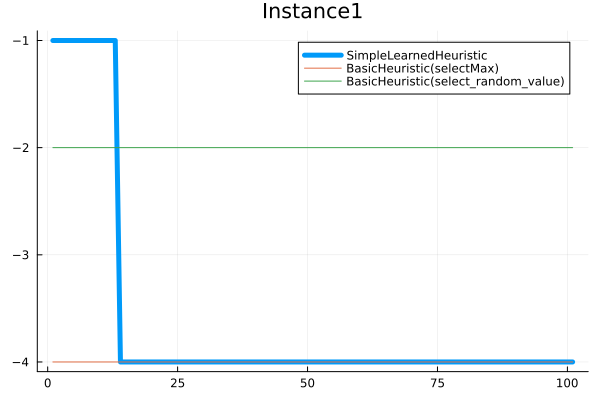

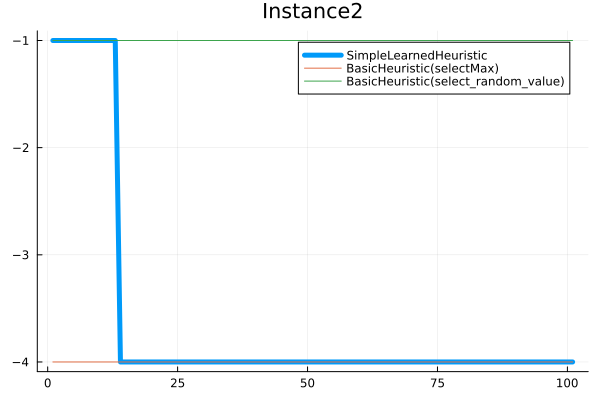

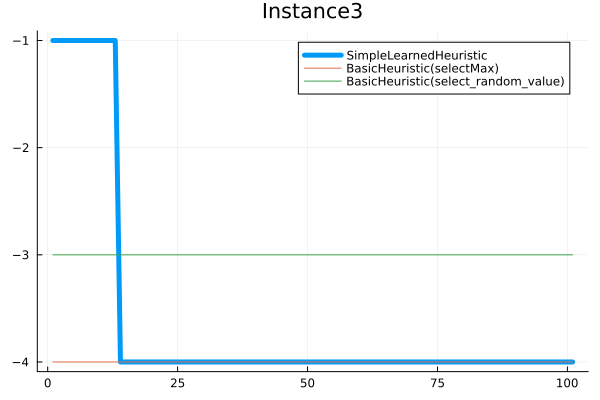

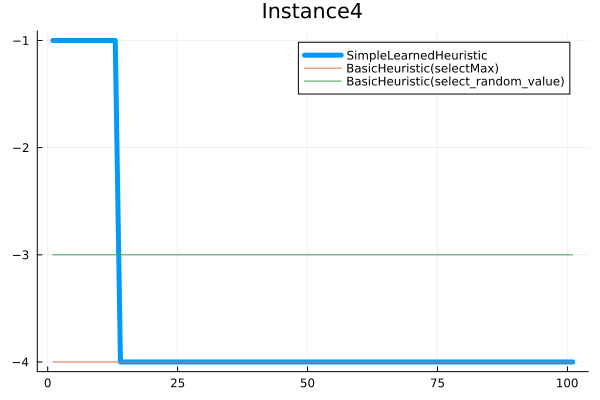

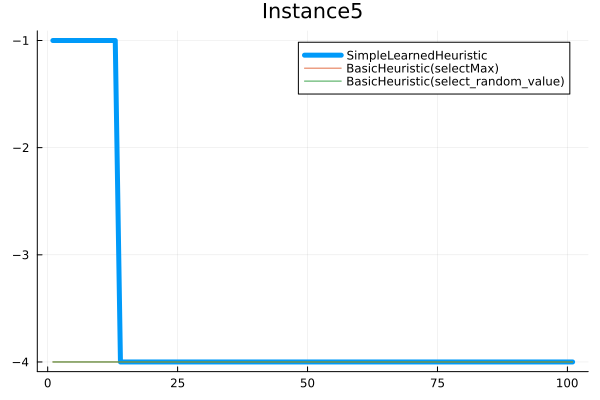

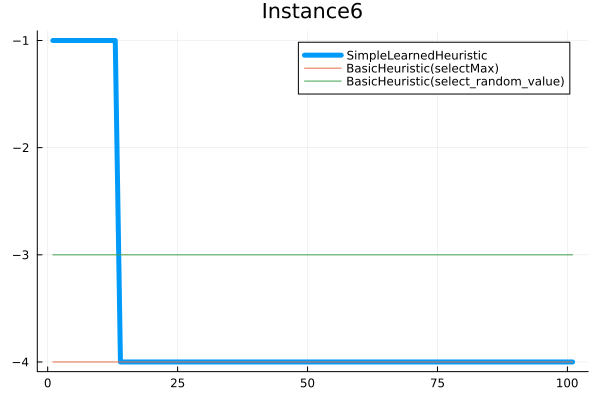

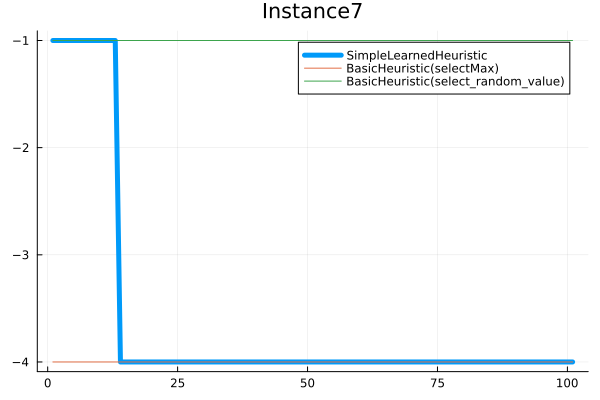

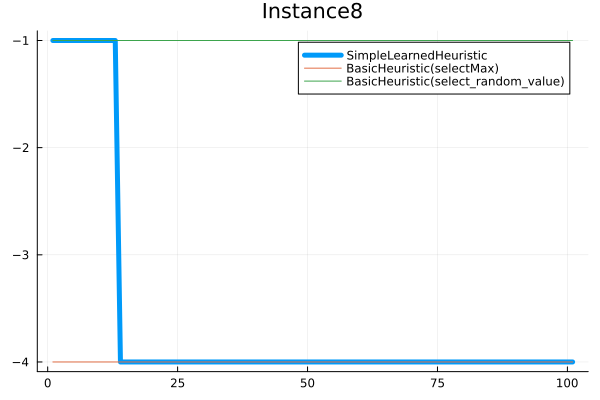

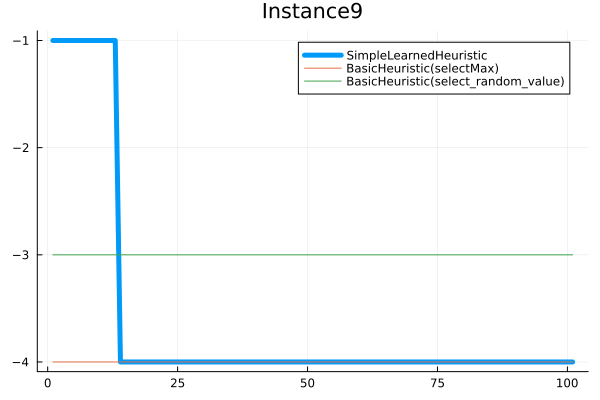

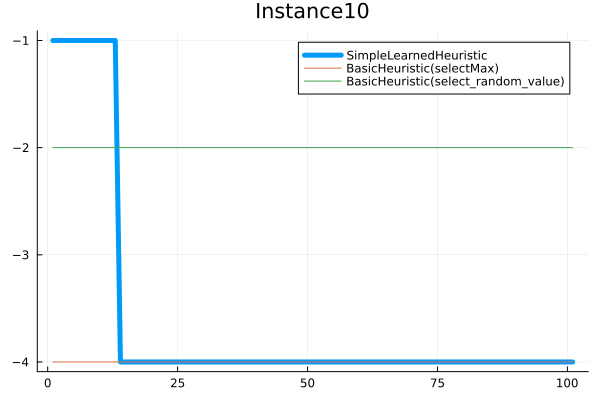

In [99]:
save_metrics(eval_metricsArray, "./results.csv")
plot_first_solution("./results.csv")

## Solve new problems with the learned heuristic

## Solve Large Problems with Pre-Trained Model